In [1]:
import requests            # for web crawling
from io import StringIO    # read and write strings as files
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone, date   # get current time
from dateutil.relativedelta import relativedelta  # offset days or months
import matplotlib.pyplot as plt   # to plot
import csv     # to export our dataframes as CSV files
import pytz    # get datetime in certain timezone (World Timezone Definitions for Python)

In [2]:
weekend = set([5, 6])                   # define weekends
offset = 1
def date_generator(offset, now):        # get dates and convert a datetime object to string
    now = now - timedelta(days=offset)
    while now.weekday() in weekend:
        now = now - timedelta(days=1)   # skip weekends
    date_str = datetime.strftime(now,'%Y-%m-%d')
    date_str = date_str.replace("-","") # turn dates to strings
    print("date_str=",date_str)
    return now, date_str
# date_generator(1,now)

# Stock Screening (Step1)
## Screen out most stocks, only pick those both domestic institution investors (DIIs) and foreign institutional investors (FIIs) have bought within the last 5 days from today.
<span style="color:red">(The information is available in public view for every investor on the daily basis)</span>

In [3]:
def replace_comma(value):               # remove commas in our data
    temp = ""
    value = str(value)
    if ',' in value:
        temp = value[0:len(value)-3].replace(',', '')
    else:
        temp = value
    return temp

def dataframe_generator(date_str):
    # crawl data from TWSE (Taiwan Stock Exchange Corporation)
    r2 = requests.get('http://www.tse.com.tw/fund/T86?response=csv&date='+date_str+'&selectType=ALLBUT0999') 
    df2 = pd.read_csv(StringIO(r2.text), header=1).dropna(how='all', axis=1).dropna(how='any')
    df2 = df2[['證券代號','證券名稱','外陸資買賣超股數(不含外資自營商)', '投信買賣超股數']]
    # units that DII & FII have bought in a given date 
    col = ["投信買賣超股數","外陸資買賣超股數(不含外資自營商)"]
    # remove commas and convert strings to integers
    df2[col] = df2[col].applymap(replace_comma).astype(int)
    # only keep those both DII and FII has bought within recent 5 days
    df2 = df2.loc[(df2["外陸資買賣超股數(不含外資自營商)"] > 0) | (df2["投信買賣超股數"] > 0)] 
    df2['外資投信同買天數'] = 0
    df2.loc[(df2["外陸資買賣超股數(不含外資自營商)"] > 0) & (df2["投信買賣超股數"] > 0), '外資投信同買天數'] = 1
#    df2 = df2.loc[df2['證券代號'].str.len() < 5]            # uncomment this line if you want to delete ETF
    return df2
#dataframe_generator(date_generator(1,now)[1])

In [4]:
df_list = []
now = datetime.now(pytz.timezone('Asia/Taipei'))  # get current local time in Taiwan (need to import pytz first)
while len(df_list) < 5:                           # append dataframes to df_list within recent five days
    now, date_str = date_generator(offset, now)
    df_list.append(dataframe_generator(date_str))
# concatenate dataframes within the last 5 days from today
new_df = pd.concat(df_list, axis=0)                 
# delete the stocks that shows Foreign Investment Institution and Domestic Institution haven't both both bought
new_df = new_df.loc[new_df["外資投信同買天數"] > 0]  

date_str= 20181221
date_str= 20181220
date_str= 20181219
date_str= 20181218
date_str= 20181217


In [5]:
grouped = new_df.groupby(['證券代號','證券名稱'], as_index=False).agg({"外陸資買賣超股數(不含外資自營商)":"sum","投信買賣超股數":"sum","外資投信同買天數":"sum"})
# sort the picked stocks in an ascending order according to the number of days both FII and DII have bought 
result = grouped.sort_values("外資投信同買天數", ascending = False) 
result['證券代號'] = result['證券代號'].str.replace('=','').str.replace('"','')
display(result)
c = np.array(result['證券代號'])     # save stock ID's in an array

證券代號            證券名稱  外陸資買賣超股數(不含外資自營商)  投信買賣超股數  外資投信同買天數
44    2610  華航                          22623     3932         5
58    3045   台灣大                         3103      835         4
21    2308   台達電                         4643      714         4
1     1102  亞泥                           3931     2745         4
78    5876    上海商銀                       9565     2614         3
45    2618   長榮航                        11840    10280         3
80    6176  瑞儀                           9174     1065         3
81    6230  超眾                            788      153         3
37    2458  義隆                           5559      418         3
75    5288  豐祥-KY                         523      112         3
74    5269  祥碩                            435      182         3
73    5234    達興材料                        218      699         3
20    2301   光寶科                         8302     1596         3
19    2228  劍麟                             83       38         3
46    2633    台灣高鐵                       6460      397         3
55    3034  聯詠                            458      605         3
8     1434  福懋                           5033     1124         3
64    3653  健策                            388      283         3
3     1303  南亞                           3331      214         3
32    2379  瑞昱                            931      275         2
47    2809   京城銀                           99      433         2
70    4766  南寶                            295      217         2
72    4977  眾達-KY                         515      541         2
51    2912   統一超                          642       70         2
66    4137  麗豐-KY                         168       45         2
41    2520  冠德                            597     1538         2
65    3665  貿聯-KY                         170       30         2
63    3533  嘉澤                            217      122         2
60    3338  泰碩                           2387      270         2
36    2412   中華電                         2151      207         2
..     ...             ...                ...      ...       ...
24    2327  國巨                            813      903         1
23    2317  鴻海                           1743      188         1
22    2313  華通                           2565      659         1
16    2059  川湖                              1       25         1
12    1590   亞德客-KY                       455       15         1
57    3041  揚智                              4      100         1
11    1536  和大                            185       30         1
9     1477  聚陽                            144       35         1
7     1409  新纖                             83      162         1
6     1402   遠東新                         3108      214         1
5     1326  台化                            345        2         1
4     1310  台苯                            135     1991         1
27    2345  智邦                           1786      425         1
28    2351  順德                             11      190         1
30    2353  宏碁                           4181      100         1
31    2355  敬鵬                             93       53         1
33    2382  廣達                           4296        7         1
35    2409  友達                           5854      188         1
38    2474  可成                             98      196         1
39    2492   華新科                          853        9         1
40    2501  國建                             22      300         1
42    2542   興富發                          534      271         1
43    2603  長榮                           3933      610         1
49    2881   富邦金                         1303       52         1
50    2886   兆豐金                          744       29         1
52    3005  神基                             61       20         1
53    3008   大立光                           51        2         1
54    3023  信邦                             57       55         1
56    3037  欣興                           9105      649         1
96  00677U  富邦VIX                       3

# Stock Screening (Step2)
## Use an EMA system that involves 5-day, 20-day, 50-day and 100-day EMAs：
．Pick stocks whose prices are in uptrend (EMA5 > EMA20 > EMA50 > EMA100)

．The slope of EMA20, EMA50 and EMA100 should be greater than 0

In [6]:
# get data within recent 6 months
def date_split(month_len):
    res = []
    now = datetime.now(pytz.timezone('Asia/Taipei'))
    for i in range(month_len):  
        date_temp = datetime.strftime(now - relativedelta(months=+i),'%Y-%m')
        date1 = date_temp.split("-")
        res.append(date1)
    return res         # export the date in the last 6 months
def to_df(df,month):
    res_df = df[0][1:]
    res_df.columns = res_df.iloc[0]
    res_df = res_df.iloc[1:].reset_index(drop=True)
    res_df = res_df.loc[res_df["日期"].str.len() < 11] # filter out blank dataframes
    res_df = res_df.loc[res_df["日期"].str.split('/').str[1] == month]
    return res_df
def load_df(x,month_len):
    # crawl data from the website: https://stock.wearn.com
    df_list=[]
    months = len(date_split(month_len))
    for i in range(months):
        url = 'https://stock.wearn.com/cdata.asp?Year='+str(int(date_split(month_len)[i][0])-1911)+'&month='+date_split(month_len)[i][1]+'&kind='+ x
        df01 = pd.read_html(url)
        res_df01 = to_df(df01,date_split(month_len)[i][1])
        df_list.append(res_df01)
    return pd.concat(df_list, ignore_index=True)
date_split(6) 

[['2018', '12'],
 ['2018', '11'],
 ['2018', '10'],
 ['2018', '09'],
 ['2018', '08'],
 ['2018', '07']]

2610


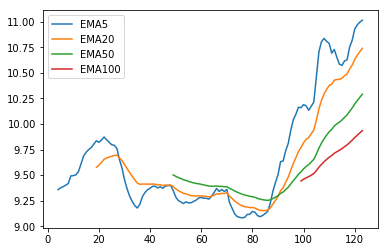

3045
2308
1102
5876
2618


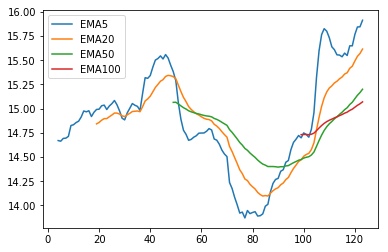

6176


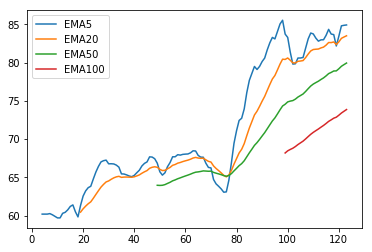

6230


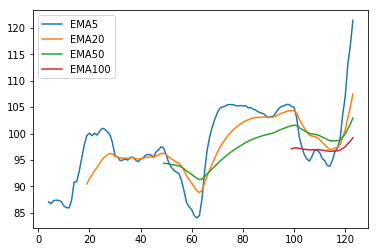

2458
5288


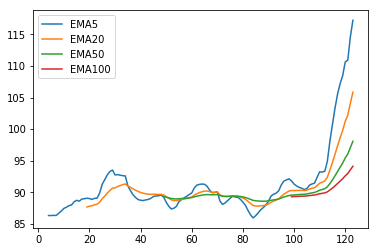

5269
5234
2301


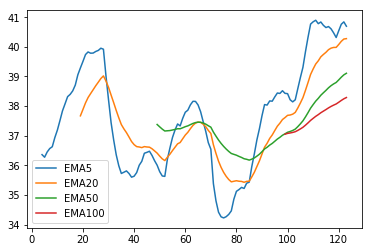

2228
2633
3034
1434


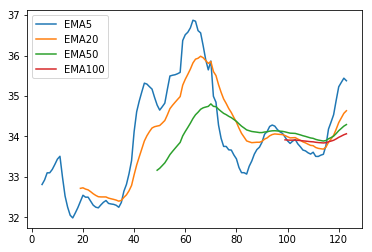

3653


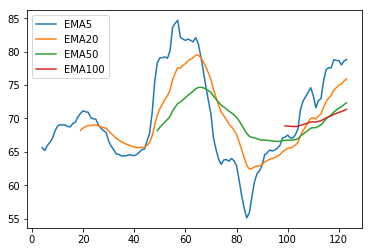

1303
2379


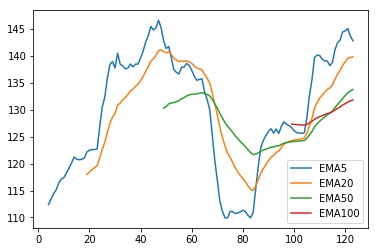

2809
4766
4977
2912
4137
2520
3665


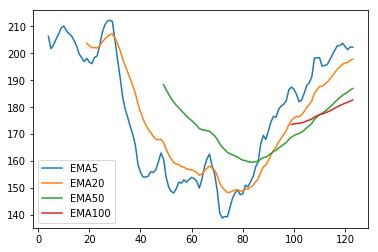

3533
3338


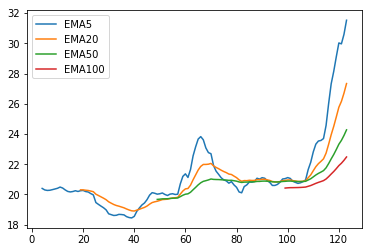

2412
2385
3406
3443
2207
1216
9941
9921
9904
1532


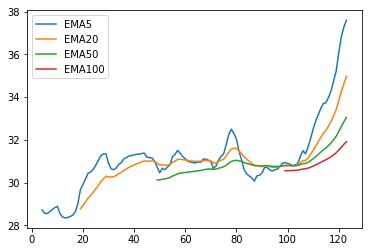

2002
2104
1722
2352
6271
6558
4915
5880
00638R


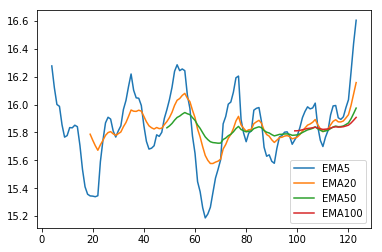

00631L
5434
6285


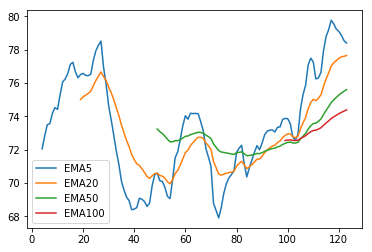

4190
4551
8499


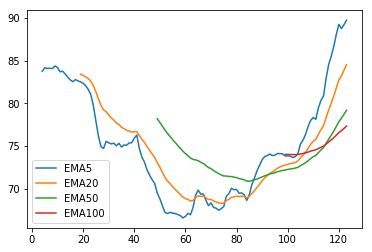

4763


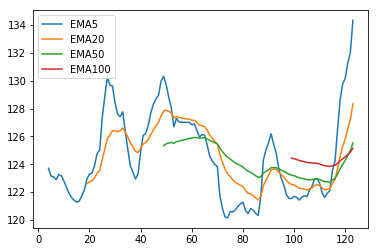

8464
8046


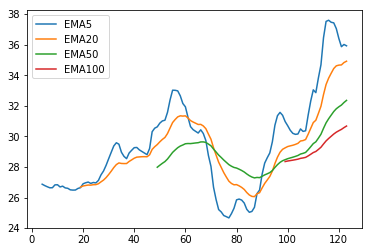

5871
6416
6670
6456
1101
2880
3189
1702
2344
2330
2327
2317
2313
2059
1590
3041
1536
1477
1409
1402
1326
1310
2345
2351
2353
2355
2382
2409
2474
2492
2501


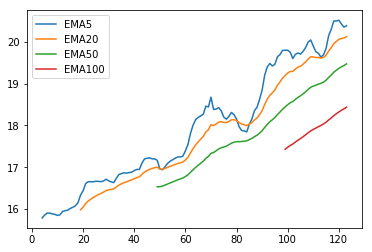

2542
2603
2881
2886
3005
3008
3023
3037


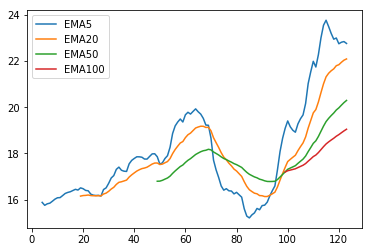

00677U


Exception: inputs are all NaN

In [7]:
import talib # for calculating exponential moving average. This API cannot be installed by using the 'pip' command
def MA(xxx):
    EMA5 = talib.EMA(xxx,5)
    EMA20 = talib.EMA(xxx,20)
    EMA50 = talib.EMA(xxx,50)
    EMA100 = talib.EMA(xxx,100)
#    print("EMA5[-1]",EMA5[-1],"EMA20[-1]",EMA20[-1],"EMA50[-1]", EMA50[-1],"EMA100[-1]",EMA100[-1], "EMA20[-2]",EMA20[-2],"EMA50[-2]",EMA50[-2],"EMA100[-2]",EMA100[-2])
    if EMA5[-1] > EMA20[-1] and EMA20[-1] > EMA50[-1] and EMA50[-1] >EMA100[-1] and EMA20[-1] > EMA20[-2] and EMA50[-1] > EMA50[-2] and EMA100[-1] > EMA100[-2]:
# EMA5 > EMA20 > EMA50 > EMA100 , and the slope of EMA20, EMA50 and EMA100 must be positive
        plt.plot(EMA5)
        plt.plot(EMA20)
        plt.plot(EMA50)
        plt.plot(EMA100)
        plt.gca().legend(('EMA5','EMA20','EMA50','EMA100'))
 # plot and see if the EMAs satisfy the stock screening criteria
        plt.show()
        return True
    else:
        return False
res_list= []
df_res = []
for x in c:
    print(x)
    load = pd.DataFrame()
# load data within recent 6 months from https://stock.wearn.com
    load = load_df(x,6)   
    xxx = np.array(load['收盤價'],dtype=float)[::-1] 
# Check if 
    if MA(xxx):
        res_list.append(x)
        df_res.append(load)

In [8]:
# Show the stocks we've picked
for i in range(len(res_list)):
    print(res_list[i])
#    display(df_res[i])
print(str(len(res_list)) + " items")

2610
2618
6176
6230
5288
2301
1434
3653
2379
3665
3338
1532
00638R
6285
8499
4763
8046
2501
3037
19 items


# Backtesting:
## Use a modified double crossover method instead. Follow a set of criteria：
## ．Buy：
### ⅰ. stock price > short EMA
### ⅱ. slope of short and long EMA > 0
### ⅲ. ( short EMA / long EMA ) > 1.02
### ⅳ. current price > EMA50
## ．Sell：
### slope of short EMA5 < 0 (when there is a pullback)
### or
### ( slope of short EMA > 0 and trading volume > 2.2*(yesterday’s) )   (when there is a volume surge)

In [11]:
#crawl data within the last two years (24 months) from https://stock.wearn.com, very time-consuming
backtest_df = []
for i in res_list:
    backtest_temp = load_df(i,24)
    backtest_df.append(backtest_temp)
    backtest_temp.to_csv(str(i)+'.csv',sep=',',encoding='utf-8')
    display(backtest_temp)

1           日期    開盤價    最高價    最低價    收盤價    成交量
0    107/12/22  11.10  11.10  11.00  11.05   2319
1    107/12/21  11.00  11.10  10.90  11.05  15148
2    107/12/20  11.10  11.20  10.95  11.05  10020
3    107/12/19  11.25  11.30  11.10  11.15  29445
4    107/12/18  11.00  11.20  10.85  10.95  20832
5    107/12/17  10.70  11.05  10.70  11.00  24288
6    107/12/14  10.65  10.80  10.55  10.65   9743
7    107/12/13  10.60  10.70  10.60  10.70   7884
8    107/12/12  10.50  10.60  10.45  10.55   7426
9    107/12/11  10.50  10.60  10.40  10.45  12306
10   107/12/10  10.65  10.70  10.40  10.50  12955
11   107/12/07  10.65  10.85  10.60  10.80  12637
12   107/12/06  10.75  10.75  10.30  10.50  21477
13   107/12/05  10.65  10.85  10.60  10.75  10421
14   107/12/04  10.85  10.95  10.60  10.75  27265
15   107/12/03  11.25  11.35  10.80  10.90  26417
16   107/11/30  11.15  11.30  10.95  11.00  21901
17   107/11/29  11.20  11.30  11.00  11.20  45788
18   107/11/28  10.40  10.95  10.40  10.95  71714
19   107/11/27  10.25  10.30  10.15  10.30  10052
20   107/11/26  10.45  10.55  10.15  10.25  19885
21   107/11/23  10.10  10.20  10.00  10.05   7195
22   107/11/22  10.25  10.30  10.10  10.15   6999
23   107/11/21  10.15  10.25  10.10  10.25   9933
24   107/11/20  10.25  10.25  10.10  10.15   9411
25   107/11/19  10.30  10.40  10.25  10.30  11023
26   107/11/16  10.30  10.35  10.15  10.20   8380
27   107/11/15  10.30  10.30  10.10  10.25  10924
28   107/11/14  10.05  10.25  10.05  10.20  22725
29   107/11/13   9.84   9.95   9.72   9.95  10697
..         ...    ...    ...    ...    ...    ...
458  106/02/20   9.89  10.00   9.82   9.93  13260
459  106/02/18   9.92   9.93   9.83   9.89   5034
460  106/02/17   9.95   9.98   9.85   9.92  11432
461  106/02/16   9.80  10.00   9.80   9.91  34800
462  106/02/15   9.60   9.73   9.57   9.69  17977
463  106/02/14   9.59   9.62   9.51   9.57   6476
464  106/02/13   9.68   9.70   9.55   9.58   8861
465  106/02/10   9.67   9.67   9.61   9.63  11232
466  106/02/09   9.61   9.62   9.54   9.59   9390
467  106/02/08   9.60   9.69   9.57   9.57  16292
468  106/02/07   9.55   9.56   9.51   9.54   9216
469  106/02/06   9.48   9.59   9.43   9.51  13747
470  106/02/03   9.42   9.46   9.39   9.42   7368
471  106/02/02   9.52   9.52   9.39   9.39   8787
472  106/01/24   9.42   9.42   9.35   9.40   6127
473  106/01/23   9.39   9.40   9.34   9.35   4860
474  106/01/20   9.33   9.35   9.32   9.34   2797
475  106/01/19   9.36   9.38   9.33   9.33   4412
476  106/01/18   9.38   9.41   9.35   9.35   3876
477  106/01/17   9.35   9.41   9.35   9.35   3761
478  106/01/16   9.42   9.42   9.35   9.37   3338
479  106/01/13   9.52   9.54   9.41   9.42   5554
480  106/01/12   9.54   9.57   9.49   9.51   7593
481  106/01/11   9.42   9.53   9.39   9.52  13556
482  106/01/10   9.35   9.41   9.34   9.38   6055
483  106/01/09   9.31   9.38   9.31   9.33   3995
484  106/01/06   9.30   9.32   9.29   9.30   3702
485  106/01/05   9.29   9.34   9.26   9.30   6414
486  106/01/04   9.27   9.28   9.26   9.28   2814
487  106/01/03   9.29   9.30   9.26   9.28   2513

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價    成交量
0    107/12/22  15.90  16.10  15.80  16.05  16374
1    107/12/21  16.00  16.00  15.75  15.85  15408
2    107/12/20  16.10  16.10  15.90  16.00  12046
3    107/12/19  15.90  16.15  15.85  16.00  30896
4    107/12/18  15.90  16.05  15.65  15.65  17326
5    107/12/17  15.55  16.00  15.55  15.85  26257
6    107/12/14  15.55  15.60  15.40  15.50   9609
7    107/12/13  15.55  15.70  15.45  15.65  11869
8    107/12/12  15.55  15.55  15.40  15.50   7147
9    107/12/11  15.50  15.60  15.45  15.55   9200
10   107/12/10  15.45  15.60  15.30  15.45   6579
11   107/12/07  15.50  15.60  15.45  15.55   6347
12   107/12/06  15.55  15.60  15.20  15.45  15515
13   107/12/05  15.65  15.75  15.55  15.60  10989
14   107/12/04  15.85  15.90  15.70  15.75  18068
15   107/12/03  16.25  16.30  15.90  15.95  26329
16   107/11/30  16.15  16.30  16.05  16.10  20208
17   107/11/29  16.35  16.40  15.95  16.15  42630
18   107/11/28  15.75  16.55  15.75  16.05  90243
19   107/11/27  14.95  15.30  14.80  15.30  25607
20   107/11/26  15.05  15.30  14.90  14.95  15577
21   107/11/23  14.65  14.70  14.60  14.65   2573
22   107/11/22  14.85  14.85  14.65  14.70   2467
23   107/11/21  14.70  14.85  14.60  14.85   7055
24   107/11/20  14.75  14.75  14.55  14.65   3672
25   107/11/19  14.85  14.85  14.70  14.80   3538
26   107/11/16  14.85  14.85  14.65  14.75   4247
27   107/11/15  14.80  14.80  14.65  14.80   6463
28   107/11/14  14.65  14.90  14.65  14.80  13993
29   107/11/13  14.45  14.50  14.35  14.50   4446
..         ...    ...    ...    ...    ...    ...
458  106/02/20  15.50  15.95  15.50  15.80  27957
459  106/02/18  15.50  15.55  15.35  15.50   8741
460  106/02/17  15.35  15.60  15.30  15.50  18923
461  106/02/16  15.30  15.45  15.25  15.35  15531
462  106/02/15  15.00  15.35  14.95  15.20  19639
463  106/02/14  15.00  15.00  14.90  14.95   4776
464  106/02/13  15.10  15.15  14.95  15.00   6938
465  106/02/10  14.95  15.10  14.95  15.00   9092
466  106/02/09  14.95  14.95  14.80  14.90   4804
467  106/02/08  15.00  15.20  14.85  14.85  12504
468  106/02/07  14.90  15.05  14.85  15.00   5524
469  106/02/06  14.85  15.05  14.85  14.90   7190
470  106/02/03  14.95  15.05  14.75  14.80   8638
471  106/02/02  15.10  15.15  14.90  14.90   8116
472  106/01/24  15.10  15.15  15.00  15.10   7723
473  106/01/23  15.10  15.15  15.00  15.00   4139
474  106/01/20  15.00  15.05  14.90  15.00   5085
475  106/01/19  15.05  15.05  14.90  14.95   3956
476  106/01/18  15.15  15.15  15.00  15.05   3226
477  106/01/17  15.00  15.25  15.00  15.15   5518
478  106/01/16  15.05  15.10  14.95  15.00   3448
479  106/01/13  15.10  15.10  15.00  15.05   3832
480  106/01/12  15.15  15.15  15.00  15.05   5145
481  106/01/11  14.90  15.20  14.80  15.10  14195
482  106/01/10  14.85  14.90  14.75  14.85   3240
483  106/01/09  14.80  14.95  14.75  14.80   3405
484  106/01/06  15.00  15.00  14.70  14.80   3826
485  106/01/05  14.65  14.95  14.60  14.90  10067
486  106/01/04  14.50  14.60  14.50  14.60   2371
487  106/01/03  14.60  14.65  14.55  14.60   2850

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價    成交量
0    107/12/22  84.40  85.00  83.90  85.00   1054
1    107/12/21  87.50  88.60  84.50  85.00   9034
2    107/12/20  85.80  87.60  85.10  87.50  10987
3    107/12/19  81.60  86.30  80.70  86.00  12336
4    107/12/18  83.00  83.30  78.70  79.20  11473
5    107/12/17  82.50  84.40  82.40  83.50   2835
6    107/12/14  85.00  85.40  82.00  82.50   5488
7    107/12/13  85.30  87.80  85.30  85.90  10604
8    107/12/12  83.00  84.70  83.00  84.70   3668
9    107/12/11  83.30  83.30  80.90  83.00   4868
10   107/12/10  82.00  84.50  81.60  83.30   5718
11   107/12/07  82.80  82.80  81.10  82.00   2204
12   107/12/06  83.10  83.30  80.40  82.10   4042
13   107/12/05  83.00  84.10  83.00  83.50   2106
14   107/12/04  85.70  86.90  83.50  85.40   6104
15   107/12/03  84.80  85.90  84.60  85.50   7038
16   107/11/30  81.90  84.30  81.70  84.30   9691
17   107/11/29  81.60  82.70  80.50  80.80   6401
18   107/11/28  81.50  81.70  79.70  80.60   6206
19   107/11/27  79.80  82.10  78.60  82.10   7499
20   107/11/26  78.50  79.90  77.80  79.90   5458
21   107/11/23  77.50  78.30  75.80  76.70   7724
22   107/11/22  81.00  82.20  77.50  77.50   9805
23   107/11/21  78.00  82.90  77.20  82.40  13722
24   107/11/20  84.50  85.80  80.10  80.10  13166
25   107/11/19  87.50  87.60  85.60  86.50   4469
26   107/11/16  86.50  87.20  85.10  87.00   8527
27   107/11/15  83.20  86.30  83.20  86.00  14804
28   107/11/14  84.70  85.00  82.70  82.70   6124
29   107/11/13  82.40  84.70  81.60  84.70   6175
..         ...    ...    ...    ...    ...    ...
458  106/02/20  61.70  62.50  61.20  61.20   3118
459  106/02/18  60.80  61.70  60.80  61.40   2054
460  106/02/17  61.00  61.40  60.30  60.80   3822
461  106/02/16  62.00  62.20  60.80  60.80   5389
462  106/02/15  62.20  62.80  61.80  62.00   6292
463  106/02/14  62.00  62.50  61.00  61.70   5314
464  106/02/13  61.10  61.80  60.60  61.60   4825
465  106/02/10  61.30  62.90  60.90  61.10   8983
466  106/02/09  61.00  61.50  60.70  60.90   5349
467  106/02/08  61.70  62.50  60.70  60.70   9940
468  106/02/07  60.90  61.00  60.30  60.70   4501
469  106/02/06  60.60  61.70  60.00  61.30  10831
470  106/02/03  57.80  61.50  57.20  61.00  17950
471  106/02/02  57.20  57.60  56.60  57.50   4783
472  106/01/24  57.20  57.20  56.60  56.60   2980
473  106/01/23  56.90  57.10  56.50  57.00   2228
474  106/01/20  56.60  57.40  56.50  56.70   2121
475  106/01/19  55.80  56.60  55.60  56.50   2204
476  106/01/18  55.90  56.00  55.60  55.80   1822
477  106/01/17  55.70  56.30  55.50  55.90   2046
478  106/01/16  56.70  56.70  55.30  55.80   2756
479  106/01/13  56.80  56.80  56.50  56.70   1007
480  106/01/12  56.90  56.90  56.40  56.80   1773
481  106/01/11  57.10  57.20  56.60  56.80   1786
482  106/01/10  56.60  56.90  56.10  56.80   2811
483  106/01/09  58.40  58.50  56.30  56.60   5058
484  106/01/06  56.90  58.00  56.90  58.00   5072
485  106/01/05  56.70  56.90  56.20  56.90   2219
486  106/01/04  56.40  56.80  56.00  56.70   2271
487  106/01/03  56.20  56.30  55.10  56.00   1919

[488 rows x 6 columns]

1           日期     開盤價     最高價     最低價     收盤價   成交量
0    107/12/22  128.00  135.50  126.50  131.00  3932
1    107/12/21  127.00  130.00  124.00  124.00  4989
2    107/12/20  112.00  125.00  112.00  125.00  4984
3    107/12/19  120.00  121.00  113.00  114.00  2327
4    107/12/18  102.50  112.50  101.50  112.50   998
5    107/12/17   98.10  105.50   98.10  102.50   579
6    107/12/14  100.00  101.50   98.60   98.60   220
7    107/12/13   98.00  101.50   98.00  100.00   468
8    107/12/12   93.80   97.20   93.80   97.20   216
9    107/12/11   93.00   93.90   93.00   93.50    77
10   107/12/10   93.70   93.70   91.70   92.20   129
11   107/12/07   94.30   96.00   93.10   94.00    88
12   107/12/06   96.00   96.00   92.00   93.10   263
13   107/12/05   95.50   95.80   95.20   95.40    66
14   107/12/04   99.40   99.40   97.00   97.00   194
15   107/12/03   98.40  100.50   98.20   99.00   397
16   107/11/30   98.90  100.00   96.00   97.50   512
17   107/11/29   95.50   95.50   92.40   93.90    97
18   107/11/28   93.00   94.40   92.90   93.60   105
19   107/11/27   94.90   95.70   91.30   93.00   258
20   107/11/26   91.10   93.60   89.60   93.60   254
21   107/11/23   99.00   99.00   90.20   92.30  1050
22   107/11/22  100.00  102.00   99.20   99.20   762
23   107/11/21  103.00  105.50  103.00  104.50   193
24   107/11/20  100.50  104.50  100.00  104.50   307
25   107/11/19  106.00  106.00  105.50  105.50   966
26   107/11/16  106.00  106.00  105.50  106.00   452
27   107/11/15  105.50  106.00  105.00  105.50  1931
28   107/11/14  106.00  106.00  105.50  106.00   594
29   107/11/13  105.50  106.00  105.50  106.00  1014
..         ...     ...     ...     ...     ...   ...
458  106/02/20  145.00  154.00  145.00  150.50  3984
459  106/02/18  146.50  147.00  145.00  145.00   361
460  106/02/17  143.00  147.50  142.50  145.50   739
461  106/02/16  145.00  145.00  143.00  143.00   522
462  106/02/15  143.00  144.50  142.00  144.50  1161
463  106/02/14  148.50  149.50  142.00  142.00  1985
464  106/02/13  149.00  149.50  145.00  148.50  1987
465  106/02/10  154.50  155.00  151.00  151.00   842
466  106/02/09  150.00  154.50  149.00  154.00  1710
467  106/02/08  148.00  152.00  147.50  148.50  1130
468  106/02/07  152.50  153.00  145.50  148.50  1744
469  106/02/06  154.50  155.50  152.50  152.50   837
470  106/02/03  157.50  157.50  152.50  153.50   926
471  106/02/02  154.00  158.00  154.00  155.50  1222
472  106/01/24  153.50  154.50  151.50  153.00   810
473  106/01/23  152.50  154.50  152.00  153.50   883
474  106/01/20  150.50  153.00  150.00  151.00   993
475  106/01/19  157.50  157.50  150.00  150.00  1831
476  106/01/18  150.50  157.00  150.00  154.50  2821
477  106/01/17  148.50  153.50  147.00  152.00  2463
478  106/01/16  149.50  149.50  146.50  149.00   976
479  106/01/13  147.00  149.00  145.00  149.00  1328
480  106/01/12  147.00  150.50  146.50  147.00  1738
481  106/01/11  147.00  148.50  146.00  147.00  2248
482  106/01/10  146.00  151.00  145.00  150.00  4216
483  106/01/09  138.50  150.00  138.00  146.00  5616
484  106/01/06  132.50  140.00  132.50  136.50  2870
485  106/01/05  134.50  135.00  132.00  133.00  1109
486  106/01/04  132.00  135.50  132.00  133.50  1005
487  106/01/03  133.50  134.00  131.50  132.00   545

[488 rows x 6 columns]

1           日期     開盤價     最高價     最低價     收盤價   成交量
0    107/12/22  119.00  123.50  117.50  122.50  1329
1    107/12/21  112.00  122.00  112.00  122.00  3052
2    107/12/20  114.00  117.00  108.00  111.50  1430
3    107/12/19  112.50  119.00  112.50  115.00  3544
4    107/12/18  111.00  111.00  108.50  111.00   986
5    107/12/17  112.00  112.50  108.00  110.50  1482
6    107/12/14  109.00  110.50  107.00  110.00  1695
7    107/12/13  107.00  111.00  105.50  108.50  3814
8    107/12/12  105.50  107.00  103.50  106.00  2416
9    107/12/11  100.00  106.50   99.80  104.50  3883
10   107/12/10   94.40   98.30   93.80   98.00  1151
11   107/12/07   95.50   96.40   93.60   93.60   842
12   107/12/06   94.60   96.80   93.00   93.10   595
13   107/12/05   94.50   99.40   94.50   95.00  2414
14   107/12/04   92.50   94.40   91.70   94.20   575
15   107/12/03   92.00   93.40   91.40   91.70   133
16   107/11/30   92.30   93.20   91.70   91.70   181
17   107/11/29   90.90   92.80   90.90   92.20   315
18   107/11/28   90.40   91.50   90.40   90.90    54
19   107/11/27   90.40   91.00   90.00   90.00    17
20   107/11/26   91.00   91.70   89.90   90.40    62
21   107/11/23   90.00   91.00   89.20   90.30    36
22   107/11/22   90.40   91.80   89.90   90.40    54
23   107/11/21   91.40   92.00   90.30   90.30    43
24   107/11/20   92.20   92.20   91.00   91.10    32
25   107/11/19   92.00   92.50   91.50   92.50    38
26   107/11/16   93.10   93.10   91.90   92.30    57
27   107/11/15   92.90   93.70   92.00   93.00   189
28   107/11/14   91.00   93.40   91.00   93.00   259
29   107/11/13   90.00   91.00   88.60   91.00    77
..         ...     ...     ...     ...     ...   ...
458  106/02/20   83.30   83.80   82.60   82.60   179
459  106/02/18   83.50   83.50   83.00   83.50   132
460  106/02/17   82.00   83.40   82.00   83.00   222
461  106/02/16   83.00   83.50   81.80   82.10   349
462  106/02/15   84.00   84.30   82.70   83.00   349
463  106/02/14   85.70   86.60   83.70   83.90   484
464  106/02/13   83.00   86.00   83.00   85.40   644
465  106/02/10   82.30   85.90   82.30   83.30  1298
466  106/02/09   82.30   82.80   81.50   81.80   352
467  106/02/08   81.70   82.80   81.60   82.20   405
468  106/02/07   83.00   83.20   81.50   81.70   476
469  106/02/06   81.50   82.80   81.20   82.40  1004
470  106/02/03   79.60   80.60   79.20   80.60   480
471  106/02/02   79.20   79.80   78.60   79.20   355
472  106/01/24   78.40   79.90   78.30   79.20   481
473  106/01/23   78.50   78.60   77.90   78.30   272
474  106/01/20   77.60   79.00   77.60   78.00   524
475  106/01/19   77.20   77.80   76.80   77.50   436
476  106/01/18   77.00   77.70   76.40   77.70   259
477  106/01/17   77.70   77.70   76.80   77.30   189
478  106/01/16   78.00   78.30   76.60   77.20   252
479  106/01/13   76.00   78.20   76.00   78.00   399
480  106/01/12   75.90   76.60   75.80   76.00   175
481  106/01/11   76.00   76.60   75.70   75.90   300
482  106/01/10   77.70   78.10   75.80   76.40   618
483  106/01/09   80.20   80.40   77.70   77.70   421
484  106/01/06   80.40   80.50   79.50   80.20   283
485  106/01/05   80.10   80.70   79.80   80.20   323
486  106/01/04   80.80   81.20   79.80   80.10   257
487  106/01/03   79.50   81.40   79.50   80.70   322

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價    成交量
0    107/12/22  40.30  40.55  40.20  40.40    881
1    107/12/21  40.80  41.05  40.65  41.00   8507
2    107/12/20  40.60  41.50  40.60  41.20   5137
3    107/12/19  40.40  41.15  40.15  41.00  11536
4    107/12/18  40.00  40.50  39.80  40.00   8852
5    107/12/17  40.35  40.50  40.20  40.20   5861
6    107/12/14  40.25  40.70  40.25  40.45   4274
7    107/12/13  40.35  40.75  40.10  40.75   6835
8    107/12/12  40.85  40.90  40.40  40.50   7336
9    107/12/11  40.05  40.65  39.90  40.50   6612
10   107/12/10  39.60  40.95  39.60  40.95   6112
11   107/12/07  40.90  41.00  40.50  40.55   4832
12   107/12/06  40.90  41.00  39.85  41.00   6282
13   107/12/05  40.95  41.30  40.55  41.00   4888
14   107/12/04  41.25  41.80  40.90  41.65  11192
15   107/12/03  40.95  41.30  40.90  41.30   8703
16   107/11/30  39.65  40.90  39.50  40.90  30517
17   107/11/29  40.20  40.25  39.80  40.00   8889
18   107/11/28  39.35  40.00  39.05  39.70  10888
19   107/11/27  38.10  39.40  38.10  39.35  11714
20   107/11/26  38.00  38.65  38.00  38.35   7293
21   107/11/23  38.00  38.30  37.70  38.00   8309
22   107/11/22  38.10  38.35  37.60  37.80   4581
23   107/11/21  38.00  38.40  37.95  38.40   6862
24   107/11/20  38.20  38.60  38.05  38.25   4688
25   107/11/19  38.25  38.90  38.25  38.70   6623
26   107/11/16  38.70  38.80  38.05  38.40   7744
27   107/11/15  38.15  38.80  38.15  38.70   6156
28   107/11/14  38.00  38.60  37.95  38.60   6314
29   107/11/13  37.60  38.65  37.45  38.15   6983
..         ...    ...    ...    ...    ...    ...
458  106/02/20  51.30  51.90  50.50  50.70   3384
459  106/02/18  51.10  51.70  50.80  51.30    872
460  106/02/17  52.40  52.60  51.10  51.10   4686
461  106/02/16  52.50  53.00  52.20  52.90   2674
462  106/02/15  52.50  53.00  51.90  52.70   5855
463  106/02/14  53.00  53.00  51.80  52.10   3863
464  106/02/13  53.00  53.20  52.60  53.00   3289
465  106/02/10  52.70  53.40  51.80  53.00   8997
466  106/02/09  50.80  52.90  50.50  52.90  11726
467  106/02/08  50.50  51.90  50.00  51.10   8922
468  106/02/07  50.00  50.50  50.00  50.50   6002
469  106/02/06  49.90  50.00  49.55  50.00   2937
470  106/02/03  49.05  50.00  48.70  50.00   9682
471  106/02/02  48.35  49.15  47.90  49.05  16271
472  106/01/24  48.40  48.40  47.15  47.20   8119
473  106/01/23  47.75  48.45  47.70  48.45   4076
474  106/01/20  47.60  48.00  47.35  47.50   4135
475  106/01/19  48.10  48.65  47.80  47.80   5197
476  106/01/18  49.00  49.55  48.40  48.40   5816
477  106/01/17  48.50  49.05  48.40  49.05   2559
478  106/01/16  49.80  49.80  48.00  48.50   3900
479  106/01/13  49.10  49.50  48.95  49.50   5051
480  106/01/12  49.90  49.95  48.75  48.90   6700
481  106/01/11  49.20  49.80  48.75  49.80   5849
482  106/01/10  49.40  49.40  48.35  48.70   4082
483  106/01/09  49.30  49.30  48.80  49.15   1618
484  106/01/06  48.65  49.15  48.65  49.00   3331
485  106/01/05  49.20  49.30  48.25  48.95   5578
486  106/01/04  48.50  49.80  48.40  49.55   4301
487  106/01/03  48.35  48.40  47.85  48.05   2537

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價   成交量
0    107/12/22  35.55  35.55  35.15  35.25   183
1    107/12/21  35.30  35.70  34.80  35.65  1508
2    107/12/20  36.00  36.10  35.15  35.55  1329
3    107/12/19  36.10  36.30  35.75  35.90  3614
4    107/12/18  35.20  36.35  35.15  35.60  5730
5    107/12/17  34.75  34.95  34.65  34.90  1277
6    107/12/14  35.00  35.00  34.35  34.70  2139
7    107/12/13  34.40  35.00  34.20  35.00  2677
8    107/12/12  33.70  34.45  33.60  34.20  2062
9    107/12/11  33.40  33.65  33.40  33.60   531
10   107/12/10  33.50  33.60  33.15  33.60  1295
11   107/12/07  33.35  33.50  33.25  33.50   726
12   107/12/06  33.70  33.70  33.15  33.30  1656
13   107/12/05  33.40  33.90  33.30  33.70  1326
14   107/12/04  33.50  33.70  33.40  33.50  1944
15   107/12/03  33.80  34.00  33.45  33.50  2064
16   107/11/30  33.60  33.70  33.40  33.60  3355
17   107/11/29  33.60  33.70  33.40  33.50  1302
18   107/11/28  33.60  33.65  33.45  33.60  1153
19   107/11/27  33.85  33.90  33.50  33.60  1241
20   107/11/26  33.95  34.20  33.85  34.00  1770
21   107/11/23  33.70  34.05  33.55  34.00  1494
22   107/11/22  33.80  33.80  33.65  33.70   600
23   107/11/21  33.65  33.85  33.35  33.70  1175
24   107/11/20  34.10  34.10  33.70  33.80   907
25   107/11/19  34.10  34.20  33.95  34.00  1029
26   107/11/16  34.10  34.25  33.90  34.00  1208
27   107/11/15  34.20  34.20  33.90  34.00  1077
28   107/11/14  34.50  34.50  33.85  34.20  1305
29   107/11/13  33.95  34.70  33.90  34.35  1556
..         ...    ...    ...    ...    ...   ...
458  106/02/20  30.85  31.20  30.85  31.20  1014
459  106/02/18  31.00  31.25  30.75  30.85   718
460  106/02/17  31.50  31.60  30.80  30.80  2322
461  106/02/16  31.50  31.80  31.25  31.60  3354
462  106/02/15  30.60  31.50  30.60  31.45  3550
463  106/02/14  30.40  30.60  30.25  30.60  1295
464  106/02/13  30.30  30.40  30.20  30.40   522
465  106/02/10  30.00  30.35  30.00  30.35   852
466  106/02/09  29.85  30.00  29.80  29.95  1348
467  106/02/08  29.85  30.05  29.80  29.85  1258
468  106/02/07  30.10  30.10  30.05  30.05   667
469  106/02/06  30.00  30.15  30.00  30.05  1309
470  106/02/03  29.45  29.90  29.45  29.90  1033
471  106/02/02  29.80  30.20  29.40  29.40  2350
472  106/01/24  30.30  30.50  30.10  30.10  1163
473  106/01/23  30.20  30.60  30.20  30.50  1352
474  106/01/20  30.00  30.15  29.80  30.00   738
475  106/01/19  30.00  30.20  30.00  30.05   796
476  106/01/18  30.35  30.55  30.00  30.00  1069
477  106/01/17  30.55  30.60  30.45  30.55   857
478  106/01/16  30.65  30.65  30.20  30.55  1044
479  106/01/13  30.40  30.55  30.35  30.55  1112
480  106/01/12  30.25  30.45  30.25  30.40  1149
481  106/01/11  30.15  30.25  30.05  30.20   671
482  106/01/10  30.05  30.25  30.00  30.10   402
483  106/01/09  30.35  30.40  30.00  30.10   454
484  106/01/06  30.00  30.40  30.00  30.30  1512
485  106/01/05  29.95  30.00  29.75  30.00   605
486  106/01/04  29.65  30.10  29.55  30.00  1105
487  106/01/03  29.40  29.70  29.25  29.65   488

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價   成交量
0    107/12/22  79.70  81.40  79.20  79.20  2969
1    107/12/21  78.20  80.90  76.50  79.80  3860
2    107/12/20  78.60  79.90  75.30  76.70  2189
3    107/12/19  79.30  81.10  78.20  78.60  2453
4    107/12/18  81.20  81.90  78.20  78.50  3675
5    107/12/17  78.80  81.20  78.30  81.20  3667
6    107/12/14  78.30  79.80  77.40  77.50  3079
7    107/12/13  83.10  84.60  78.20  78.20  7791
8    107/12/12  80.80  81.70  79.30  80.80  7078
9    107/12/11  74.50  80.80  74.30  80.80  8437
10   107/12/10  74.50  74.50  72.00  73.50  1986
11   107/12/07  71.50  74.80  71.00  74.80  4964
12   107/12/06  71.20  72.00  67.40  68.00  1282
13   107/12/05  74.50  74.70  70.00  71.00  1636
14   107/12/04  77.00  77.30  75.50  76.00  1008
15   107/12/03  77.00  77.80  75.10  75.20  1636
16   107/11/30  75.80  77.10  74.50  74.60  1444
17   107/11/29  78.10  78.60  75.10  75.10  4596
18   107/11/28  75.80  77.20  75.80  77.20  3259
19   107/11/27  69.00  70.70  67.90  70.20  1081
20   107/11/26  67.90  69.90  67.50  68.50  1171
21   107/11/23  66.80  68.10  66.30  67.10   463
22   107/11/22  68.50  68.80  66.20  66.20   448
23   107/11/21  66.60  68.70  66.20  68.10   499
24   107/11/20  69.00  69.00  67.00  67.50   605
25   107/11/19  66.90  69.40  66.90  69.20  1067
26   107/11/16  67.00  67.40  66.20  66.90   470
27   107/11/15  66.50  67.60  65.50  66.10   424
28   107/11/14  66.50  68.60  65.50  65.60  1098
29   107/11/13  63.50  65.30  62.50  64.80   702
..         ...    ...    ...    ...    ...   ...
458  106/02/20  58.90  59.40  58.00  58.30   773
459  106/02/18  58.70  59.00  57.50  58.00   478
460  106/02/17  58.80  59.90  58.20  58.70   987
461  106/02/16  57.00  59.20  56.90  58.20  1378
462  106/02/15  56.00  57.60  55.80  56.50   430
463  106/02/14  57.80  57.90  54.10  55.80   520
464  106/02/13  57.80  57.80  56.60  57.40   436
465  106/02/10  57.30  58.90  56.50  56.60  1093
466  106/02/09  56.50  57.50  56.00  56.30   539
467  106/02/08  56.50  58.50  55.60  56.70  1754
468  106/02/07  50.90  54.30  50.90  54.30  1187
469  106/02/06  51.90  51.90  50.80  51.00   148
470  106/02/03  51.20  52.30  50.40  51.00   243
471  106/02/02  49.35  50.90  49.35  50.90   169
472  106/01/24  50.20  50.20  48.95  49.35   280
473  106/01/23  50.10  50.20  49.35  50.10   117
474  106/01/20  49.50  50.10  49.50  49.75    64
475  106/01/19  50.00  50.10  49.40  49.70    66
476  106/01/18  50.00  50.00  49.80  50.00    69
477  106/01/17  50.50  50.50  49.70  50.10    86
478  106/01/16  50.90  50.90  49.80  50.00   115
479  106/01/13  49.80  49.90  49.80  49.80    80
480  106/01/12  50.90  50.90  50.00  50.10   127
481  106/01/11  50.00  50.50  49.70  49.70   103
482  106/01/10  49.85  50.90  49.85  50.00   136
483  106/01/09  51.40  51.40  49.20  49.85   217
484  106/01/06  52.80  52.80  51.00  51.40   363
485  106/01/05  48.55  53.10  48.55  52.40  1075
486  106/01/04  48.50  48.65  48.10  48.50    56
487  106/01/03  47.60  48.00  47.60  47.95    35

[488 rows x 6 columns]

1           日期     開盤價     最高價     最低價     收盤價    成交量
0    107/12/22  141.00  142.00  140.00  141.00    326
1    107/12/21  145.00  145.50  139.50  141.00   3148
2    107/12/20  145.00  147.50  143.50  146.00   2576
3    107/12/19  149.00  149.50  144.50  145.00   2023
4    107/12/18  143.50  148.00  143.00  147.50   2707
5    107/12/17  145.50  149.50  143.50  144.00   2081
6    107/12/14  145.50  147.00  140.50  145.00   3535
7    107/12/13  140.50  147.00  140.50  146.00   5233
8    107/12/12  139.00  140.00  137.00  140.00   1590
9    107/12/11  141.00  142.50  136.00  136.50   2252
10   107/12/10  135.00  139.50  135.00  139.00   1148
11   107/12/07  139.50  141.00  137.50  138.50   2243
12   107/12/06  139.00  140.00  135.50  138.00   3804
13   107/12/05  137.50  142.00  135.50  140.00   2988
14   107/12/04  147.50  148.00  141.00  141.00   4382
15   107/12/03  145.00  151.00  145.00  148.00   6033
16   107/11/30  141.00  142.50  138.00  141.50   3877
17   107/11/29  137.00  142.50  137.00  141.00  10641
18   107/11/28  127.00  135.00  127.00  134.00   7638
19   107/11/27  125.00  126.00  124.00  126.00   2720
20   107/11/26  125.50  128.50  123.00  125.50   2510
21   107/11/23  124.00  126.50  122.50  125.50   2515
22   107/11/22  127.00  127.50  124.00  125.00   1841
23   107/11/21  125.50  127.00  121.00  125.00   3538
24   107/11/20  126.00  126.50  124.00  126.00   1612
25   107/11/19  127.50  127.50  125.00  126.50   1226
26   107/11/16  130.00  130.00  125.50  126.50   2357
27   107/11/15  129.50  130.50  126.50  129.50   2502
28   107/11/14  125.50  131.50  125.00  129.50   4312
29   107/11/13  124.00  127.50  123.00  124.00   2441
..         ...     ...     ...     ...     ...    ...
458  106/02/20  117.00  117.00  114.00  114.00   1301
459  106/02/18  119.50  119.50  117.00  117.00    760
460  106/02/17  114.50  118.50  114.00  118.50   3225
461  106/02/16  117.00  117.50  114.00  114.00   1772
462  106/02/15  117.50  118.50  115.00  116.00   2097
463  106/02/14  122.00  122.00  116.50  116.50   2517
464  106/02/13  120.00  121.50  119.00  120.50   3486
465  106/02/10  121.00  122.00  117.00  119.50   8680
466  106/02/09  113.00  119.50  112.50  119.50  15485
467  106/02/08  110.00  111.00  108.50  109.00   2996
468  106/02/07  109.50  110.00  107.50  109.00   2662
469  106/02/06  106.50  110.00  106.00  109.00   2788
470  106/02/03  105.50  106.50  105.00  106.50   1634
471  106/02/02  108.00  108.00  104.50  105.50   3264
472  106/01/24  108.50  110.00  108.50  109.00   1407
473  106/01/23  112.50  112.50  108.00  108.50   2187
474  106/01/20  108.00  110.00  107.00  110.00   2800
475  106/01/19  108.00  109.50  107.50  108.50   1405
476  106/01/18  109.00  109.50  107.50  108.00   2424
477  106/01/17  108.00  109.00  107.50  109.00   2500
478  106/01/16  107.00  108.00  105.00  107.50   2075
479  106/01/13  105.00  107.00  104.50  107.00   2195
480  106/01/12  104.00  105.50  103.50  105.00   2401
481  106/01/11  101.50  104.00  101.50  103.50   2763
482  106/01/10  101.00  102.00  100.50  101.50   1152
483  106/01/09  101.00  101.50  100.50  101.00    926
484  106/01/06  101.50  102.00  100.50  101.00   1145
485  106/01/05  101.00  102.50  100.00  101.50   2108
486  106/01/04  102.50  102.50  100.00  100.50   1185
487  106/01/03  102.00  102.50  101.50  102.00    291

[488 rows x 6 columns]

1           日期     開盤價     最高價     最低價     收盤價   成交量
0    107/12/22  203.50  204.00  201.50  202.00   523
1    107/12/21  194.50  204.50  194.50  204.50  2667
2    107/12/20  199.50  203.50  195.50  199.00  1590
3    107/12/19  203.50  206.00  200.00  200.00  1603
4    107/12/18  199.50  205.50  197.50  205.50  2215
5    107/12/17  206.00  208.50  203.00  203.00  1465
6    107/12/14  210.00  211.00  205.00  206.00  2687
7    107/12/13  206.00  210.50  205.00  205.00  2356
8    107/12/12  204.50  207.50  202.50  203.00  2485
9    107/12/11  199.00  204.50  198.00  201.00  2640
10   107/12/10  191.00  196.50  191.00  196.50  1489
11   107/12/07  193.50  197.00  193.00  196.00  2762
12   107/12/06  201.00  202.50  187.00  189.00  4949
13   107/12/05  194.00  204.00  192.00  198.50  4142
14   107/12/04  213.00  216.00  198.50  198.50  4997
15   107/12/03  202.00  215.00  201.00  212.00  5290
16   107/11/30  191.00  197.00  191.00  196.00  2420
17   107/11/29  197.00  199.00  191.00  191.00  2907
18   107/11/28  190.00  195.50  187.50  194.00  3917
19   107/11/27  186.50  193.50  185.50  190.00  5819
20   107/11/26  182.00  186.50  180.00  184.00  3993
21   107/11/23  182.00  184.00  176.50  176.50  3193
22   107/11/22  187.50  189.50  181.00  181.00  3668
23   107/11/21  187.00  192.00  183.00  185.00  4851
24   107/11/20  191.00  194.50  188.50  189.50  4730
25   107/11/19  188.00  194.50  185.00  194.50  5999
26   107/11/16  183.00  189.50  182.00  185.00  5350
27   107/11/15  186.00  189.00  181.50  182.50  5876
28   107/11/14  183.50  188.00  181.00  183.00  5732
29   107/11/13  167.00  185.00  165.00  185.00  6829
..         ...     ...     ...     ...     ...   ...
458  106/02/20  183.50  187.00  179.50  179.50  1195
459  106/02/18  180.00  186.00  179.00  184.00  2255
460  106/02/17  179.50  179.50  176.50  177.50  1280
461  106/02/16  183.00  183.00  179.00  179.50  1628
462  106/02/15  189.00  189.00  182.50  183.00  2357
463  106/02/14  183.00  193.00  183.00  185.00  7771
464  106/02/13  173.00  181.00  171.50  177.50  2369
465  106/02/10  177.00  177.50  171.00  171.50  1375
466  106/02/09  169.50  174.50  169.50  173.00  1822
467  106/02/08  166.00  170.00  166.00  168.50   853
468  106/02/07  166.00  168.00  166.00  166.50  1214
469  106/02/06  170.00  171.00  169.00  170.00   749
470  106/02/03  169.00  173.50  168.00  170.00  1569
471  106/02/02  165.50  168.50  165.00  168.00  1050
472  106/01/24  166.00  166.00  163.50  165.00   744
473  106/01/23  166.50  168.00  163.00  163.00  1061
474  106/01/20  165.00  167.50  165.00  166.00   907
475  106/01/19  167.50  168.00  164.50  164.50   902
476  106/01/18  169.00  169.50  166.50  168.00   827
477  106/01/17  170.00  170.50  168.50  170.00   295
478  106/01/16  171.00  171.00  168.50  169.50   406
479  106/01/13  170.50  171.00  168.50  168.50   500
480  106/01/12  170.50  171.50  169.00  170.50   677
481  106/01/11  175.00  175.50  170.50  170.50  1309
482  106/01/10  173.00  174.00  171.50  172.50   579
483  106/01/09  178.00  179.50  171.50  171.50  1655
484  106/01/06  175.00  178.00  174.50  175.50  2197
485  106/01/05  171.50  174.00  171.50  172.50  1761
486  106/01/04  168.00  170.50  168.00  169.50   471
487  106/01/03  167.00  170.50  166.50  168.50   973

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價    成交量
0    107/12/22  32.10  33.55  31.55  33.40  14556
1    107/12/21  30.45  31.85  29.40  31.85   8500
2    107/12/20  31.35  31.65  29.10  29.85   8589
3    107/12/19  31.45  32.20  30.30  31.85  14485
4    107/12/18  30.30  31.40  30.25  31.05  13916
5    107/12/17  30.30  31.35  29.05  29.80  16179
6    107/12/14  28.90  30.00  28.45  29.95  10912
7    107/12/13  27.80  28.90  27.30  28.90  12919
8    107/12/12  24.20  26.30  24.10  26.30   4317
9    107/12/11  24.00  24.10  23.35  23.95    486
10   107/12/10  23.60  24.10  23.35  23.65    661
11   107/12/07  24.45  25.15  23.85  23.95   1767
12   107/12/06  24.30  24.80  23.20  24.35   2300
13   107/12/05  22.40  24.20  22.40  24.20   1426
14   107/12/04  23.25  24.15  22.85  23.10   2108
15   107/12/03  21.50  23.25  21.50  23.00   1538
16   107/11/30  21.00  21.25  21.00  21.20    297
17   107/11/29  21.00  21.05  20.75  21.00    240
18   107/11/28  20.45  20.95  20.45  20.85    135
19   107/11/27  20.65  20.65  20.35  20.60    156
20   107/11/26  20.70  21.00  20.65  20.65    131
21   107/11/23  21.20  21.20  20.15  20.50    573
22   107/11/22  21.65  21.80  20.95  20.95    634
23   107/11/21  21.00  21.25  20.80  21.25    443
24   107/11/20  21.25  21.30  21.05  21.10    175
25   107/11/19  21.45  21.45  21.10  21.45    289
26   107/11/16  21.20  21.30  20.95  21.10    315
27   107/11/15  20.45  20.95  20.45  20.80    177
28   107/11/14  20.15  20.70  20.10  20.60    213
29   107/11/13  20.35  20.35  20.10  20.20    257
..         ...    ...    ...    ...    ...    ...
458  106/02/20  33.05  33.30  32.20  32.20   1090
459  106/02/18  33.00  33.90  33.00  33.00   1140
460  106/02/17  32.35  33.50  32.20  33.00   1124
461  106/02/16  32.60  32.75  32.05  32.20    686
462  106/02/15  32.95  33.45  32.30  32.50   1642
463  106/02/14  30.50  33.10  30.40  33.10   2583
464  106/02/13  30.60  30.90  29.30  30.10   1535
465  106/02/10  31.45  31.45  30.50  30.60    732
466  106/02/09  31.40  31.70  31.30  31.30    390
467  106/02/08  32.20  32.20  31.55  31.55    468
468  106/02/07  31.70  32.10  31.70  32.00    274
469  106/02/06  31.75  31.80  31.60  31.70    309
470  106/02/03  31.80  32.45  31.80  32.00    381
471  106/02/02  31.90  31.90  31.40  31.75    185
472  106/01/24  31.80  31.95  31.35  31.60    712
473  106/01/23  32.15  32.25  31.75  31.80    398
474  106/01/20  32.10  32.55  32.10  32.15    332
475  106/01/19  33.10  33.10  32.10  32.15    569
476  106/01/18  32.70  33.20  32.70  32.80    423
477  106/01/17  32.05  33.00  32.05  32.90    680
478  106/01/16  32.90  32.95  31.95  32.10    843
479  106/01/13  33.15  33.50  32.80  33.15    575
480  106/01/12  32.80  33.25  32.65  33.15    428
481  106/01/11  33.15  33.15  32.60  32.60    544
482  106/01/10  33.20  33.35  32.80  32.95   1090
483  106/01/09  34.55  34.70  33.85  34.00    752
484  106/01/06  34.65  34.75  34.10  34.25    976
485  106/01/05  34.35  35.20  34.35  34.65   2334
486  106/01/04  34.40  35.00  34.20  34.25   2324
487  106/01/03  34.35  34.70  33.90  33.90   1609

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價   成交量
0    107/12/22  38.00  38.40  37.10  38.25  1252
1    107/12/21  38.15  38.20  37.30  38.20  2459
2    107/12/20  38.20  38.90  37.30  38.30  6805
3    107/12/19  36.15  37.80  36.15  37.80  5502
4    107/12/18  36.20  36.65  35.70  36.15  2757
5    107/12/17  35.10  36.65  35.05  35.70  5149
6    107/12/14  34.20  34.95  34.10  34.90  1377
7    107/12/13  34.10  34.95  34.00  34.50  3304
8    107/12/12  34.15  34.35  33.70  33.80   813
9    107/12/11  34.40  34.80  33.90  34.15  1535
10   107/12/10  33.70  34.15  33.40  34.10  1092
11   107/12/07  33.95  34.40  33.25  33.75  1266
12   107/12/06  33.60  34.05  32.65  33.65  2448
13   107/12/05  32.50  33.40  32.30  33.40  1519
14   107/12/04  32.30  32.85  32.20  32.85   999
15   107/12/03  32.15  32.70  32.00  32.30  1537
16   107/11/30  32.40  33.00  31.05  31.05  2749
17   107/11/29  32.15  32.20  31.85  32.00  1067
18   107/11/28  31.25  32.25  31.10  31.95  1970
19   107/11/27  31.25  31.25  30.65  31.00   902
20   107/11/26  30.30  31.00  30.30  30.90   320
21   107/11/23  31.00  31.10  30.60  30.65   481
22   107/11/22  30.80  31.00  30.65  30.80   341
23   107/11/21  30.60  30.80  30.35  30.80   257
24   107/11/20  31.20  31.25  30.85  31.00   410
25   107/11/19  31.40  31.40  30.95  31.20   271
26   107/11/16  31.10  31.30  30.80  31.00   550
27   107/11/15  31.20  31.50  30.65  30.70   990
28   107/11/14  30.70  31.05  30.45  30.70   394
29   107/11/13  29.95  30.55  29.70  30.45   380
..         ...    ...    ...    ...    ...   ...
458  106/02/20  32.40  32.55  32.20  32.20   316
459  106/02/18  32.70  32.75  32.45  32.60   209
460  106/02/17  32.60  32.60  32.40  32.60   341
461  106/02/16  32.80  32.90  32.25  32.40   387
462  106/02/15  32.20  33.00  32.10  32.70   979
463  106/02/14  32.30  32.40  32.00  32.05   320
464  106/02/13  31.90  32.35  31.85  32.30   544
465  106/02/10  32.50  32.70  32.00  32.05   532
466  106/02/09  32.40  32.50  32.20  32.40   453
467  106/02/08  32.15  32.60  32.15  32.50   492
468  106/02/07  32.45  32.50  32.15  32.15   516
469  106/02/06  31.90  33.20  31.90  32.60  1744
470  106/02/03  31.35  31.75  31.30  31.70   524
471  106/02/02  31.50  31.80  31.35  31.35   540
472  106/01/24  31.00  31.45  30.95  31.45   662
473  106/01/23  31.10  31.25  30.95  31.00   444
474  106/01/20  31.40  31.40  31.10  31.10   211
475  106/01/19  31.50  31.60  31.25  31.40   331
476  106/01/18  31.00  31.50  30.80  31.50   415
477  106/01/17  31.10  31.15  30.90  31.00   235
478  106/01/16  31.20  31.30  31.00  31.10   134
479  106/01/13  31.20  31.30  31.20  31.25    85
480  106/01/12  31.50  31.50  31.15  31.20   441
481  106/01/11  31.50  31.60  31.20  31.25   377
482  106/01/10  31.00  31.30  31.00  31.30   467
483  106/01/09  31.55  31.55  31.05  31.05   381
484  106/01/06  31.70  31.70  31.45  31.55   367
485  106/01/05  31.70  31.85  31.60  31.65   320
486  106/01/04  31.80  31.80  31.55  31.60   265
487  106/01/03  31.90  32.10  31.70  31.70   167

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價   成交量
0    107/12/22  16.86  17.01  16.86  16.94    63
1    107/12/21  16.60  16.85  16.55  16.85   252
2    107/12/20  16.26  16.63  16.26  16.63   348
3    107/12/19  16.05  16.17  16.05  16.15    98
4    107/12/18  16.07  16.16  15.95  16.11   280
5    107/12/17  15.90  16.01  15.90  15.95   183
6    107/12/14  15.82  15.96  15.81  15.87   856
7    107/12/13  15.92  15.94  15.66  15.73   542
8    107/12/12  15.93  16.02  15.93  16.00    53
9    107/12/11  16.10  16.13  16.05  16.12   117
10   107/12/10  16.09  16.17  16.01  16.15   216
11   107/12/07  15.85  15.91  15.83  15.91   216
12   107/12/06  15.72  15.93  15.72  15.90   322
13   107/12/05  15.70  15.72  15.55  15.61   268
14   107/12/04  15.48  15.55  15.48  15.55   150
15   107/12/03  15.53  15.65  15.38  15.50  1009
16   107/11/30  16.07  16.08  15.96  16.08   109
17   107/11/29  15.85  15.99  15.81  15.99    94
18   107/11/28  16.12  16.15  15.94  15.94   152
19   107/11/27  16.05  16.11  16.02  16.05   333
20   107/11/26  16.06  16.09  15.94  16.04   273
21   107/11/23  15.90  16.05  15.89  16.05   227
22   107/11/22  15.79  15.96  15.78  15.95   297
23   107/11/21  15.95  16.00  15.78  15.84   310
24   107/11/20  15.72  15.85  15.63  15.81   328
25   107/11/19  15.69  15.71  15.52  15.60   474
26   107/11/16  15.63  15.85  15.62  15.71   137
27   107/11/15  15.87  15.92  15.81  15.81   119
28   107/11/14  15.80  15.89  15.68  15.85   208
29   107/11/13  16.03  16.17  15.80  15.80   737
..         ...    ...    ...    ...    ...   ...
458  106/02/20  17.67  17.67  17.50  17.50    57
459  106/02/18  17.71  17.71  17.71  17.71     2
460  106/02/17  17.53  17.61  17.50  17.61    40
461  106/02/16  17.57  17.57  17.57  17.57    55
462  106/02/15  17.71  17.71  17.55  17.58   168
463  106/02/14  17.58  17.63  17.58  17.63    14
464  106/02/13  17.63  17.63  17.59  17.60    37
465  106/02/10  17.71  17.71  17.65  17.65    83
466  106/02/09  17.85  17.85  17.72  17.73   215
467  106/02/08  17.88  17.93  17.88  17.90    78
468  106/02/07  17.80  17.86  17.80  17.86     9
469  106/02/06  17.82  17.82  17.76  17.78    60
470  106/02/03  17.78  17.86  17.78  17.82    73
471  106/02/02  17.83  17.83  17.70  17.76    34
472  106/01/24  17.89  17.89  17.84  17.84    18
473  106/01/23  17.90  17.90  17.79  17.87    79
474  106/01/20  17.94  17.97  17.90  17.93    53
475  106/01/19  17.96  17.98  17.91  17.96    35
476  106/01/18  18.09  18.09  17.95  18.00   228
477  106/01/17  18.18  18.18  18.06  18.09    54
478  106/01/16  18.05  18.26  18.02  18.22   253
479  106/01/13  18.12  18.12  18.06  18.06    31
480  106/01/12  18.12  18.12  18.08  18.10   170
481  106/01/11  18.03  18.13  18.01  18.12   116
482  106/01/10  18.06  18.06  18.03  18.03    20
483  106/01/09  18.05  18.05  18.01  18.03   116
484  106/01/06  18.00  18.06  18.00  18.01    16
485  106/01/05  18.00  18.06  17.98  17.99   191
486  106/01/04  18.20  18.20  18.12  18.12    58
487  106/01/03  18.42  18.42  18.22  18.22   231

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價    成交量
0    107/12/22  77.50  78.60  77.50  78.10   1139
1    107/12/21  78.20  79.00  76.80  77.90   3084
2    107/12/20  78.50  79.40  77.70  78.40   3775
3    107/12/19  79.50  80.30  78.70  78.80   5662
4    107/12/18  78.80  79.70  78.10  78.60   3087
5    107/12/17  82.90  83.30  79.10  79.10   6961
6    107/12/14  81.00  82.10  79.20  80.90   6036
7    107/12/13  80.90  81.70  79.10  80.00   4870
8    107/12/12  80.30  81.40  79.60  80.50   6803
9    107/12/11  78.10  80.50  78.10  80.50   8383
10   107/12/10  76.40  78.00  75.70  77.30   3465
11   107/12/07  75.50  77.30  75.30  76.40   2390
12   107/12/06  76.90  77.60  73.60  74.20   3700
13   107/12/05  77.10  77.40  76.10  76.80   2514
14   107/12/04  79.50  79.50  78.20  78.30   2657
15   107/12/03  78.40  80.50  77.50  79.50   5986
16   107/11/30  77.00  77.80  76.00  77.00   3681
17   107/11/29  78.20  78.80  76.80  77.00   4474
18   107/11/28  74.40  78.90  74.30  77.50  10272
19   107/11/27  72.50  73.70  72.20  73.60   2298
20   107/11/26  71.80  72.40  71.30  72.20   1294
21   107/11/23  73.20  73.20  70.80  71.10   2154
22   107/11/22  74.10  74.10  73.00  73.00   1197
23   107/11/21  73.50  74.40  73.40  73.80   1063
24   107/11/20  74.70  75.40  73.60  74.00   2394
25   107/11/19  73.50  75.00  73.50  74.70   2477
26   107/11/16  74.00  74.30  73.30  73.40   1064
27   107/11/15  72.80  74.00  72.40  73.90   1297
28   107/11/14  73.50  73.80  72.70  72.80   1490
29   107/11/13  72.10  73.30  71.30  73.20   1928
..         ...    ...    ...    ...    ...    ...
458  106/02/20  92.00  92.40  91.10  91.20   1125
459  106/02/18  91.80  92.30  91.00  91.20    804
460  106/02/17  92.00  92.80  91.80  91.80   1053
461  106/02/16  95.00  95.20  91.80  91.80   2895
462  106/02/15  92.00  95.20  92.00  94.30   4890
463  106/02/14  90.20  92.10  90.10  91.30   1837
464  106/02/13  91.10  91.10  89.80  89.90   1545
465  106/02/10  91.90  91.90  89.90  91.10   2461
466  106/02/09  90.70  91.70  90.70  91.30   1369
467  106/02/08  91.50  92.20  90.80  92.20   1313
468  106/02/07  91.90  92.40  90.70  91.10   1764
469  106/02/06  89.20  91.80  89.20  91.30   2809
470  106/02/03  88.60  89.50  88.30  89.00   1173
471  106/02/02  90.30  90.50  88.30  88.50   1674
472  106/01/24  90.00  90.10  89.20  89.40    934
473  106/01/23  89.70  90.10  88.70  89.50   1467
474  106/01/20  90.70  90.90  89.70  89.70    546
475  106/01/19  90.70  91.50  90.50  90.70    755
476  106/01/18  90.80  92.10  90.20  90.70   1315
477  106/01/17  91.00  91.30  90.30  90.80    610
478  106/01/16  91.30  92.00  90.80  90.90   1254
479  106/01/13  89.40  91.40  89.10  91.10   1580
480  106/01/12  90.40  90.80  89.10  89.30    628
481  106/01/11  90.50  90.70  89.70  90.30    686
482  106/01/10  90.50  90.70  89.40  90.10    760
483  106/01/09  90.00  90.80  89.40  90.10   1641
484  106/01/06  89.70  89.70  88.80  89.50   1634
485  106/01/05  88.10  89.40  87.90  89.20   2224
486  106/01/04  87.90  88.40  87.30  87.60   1554
487  106/01/03  86.70  87.20  86.20  87.10    788

[488 rows x 6 columns]

1           日期     開盤價     最高價     最低價     收盤價   成交量
0    107/12/22   90.80   91.70   90.70   90.80    71
1    107/12/21   88.90   90.60   87.50   90.10   115
2    107/12/20   91.50   93.00   86.80   87.80   191
3    107/12/19   91.60   94.80   91.00   91.60   212
4    107/12/18   89.10   92.00   88.90   90.90   266
5    107/12/17   87.40   89.00   86.90   89.00    82
6    107/12/14   88.10   88.50   86.10   87.40    49
7    107/12/13   87.00   89.90   86.50   87.80   149
8    107/12/12   82.40   87.30   82.00   87.00   159
9    107/12/11   80.50   83.00   80.50   81.90    38
10   107/12/10   81.70   86.50   80.50   82.00   178
11   107/12/07   78.80   83.10   78.80   82.20   147
12   107/12/06   79.00   79.00   77.60   77.70    40
13   107/12/05   78.90   79.00   78.50   79.00    30
14   107/12/04   79.00   79.50   79.00   79.40    18
15   107/12/03   78.00   79.40   77.50   79.20    64
16   107/11/30   76.30   78.20   76.30   77.70    44
17   107/11/29   77.70   77.70   76.60   76.60    24
18   107/11/28   75.00   77.90   75.00   77.50    93
19   107/11/27   73.60   74.80   73.60   74.80    36
20   107/11/26   73.10   74.20   73.10   74.00    17
21   107/11/23   73.80   74.10   73.30   73.30    28
22   107/11/22   74.10   74.40   73.70   73.70    19
23   107/11/21   74.00   74.10   73.30   73.90    11
24   107/11/20   73.80   73.80   73.30   73.30    21
25   107/11/19   74.40   74.50   73.70   74.00    21
26   107/11/16   74.40   74.40   74.10   74.10    13
27   107/11/15   74.00   74.60   74.00   74.50    34
28   107/11/14   73.10   74.70   72.80   74.00    28
29   107/11/13   73.00   73.50   73.00   73.50    20
..         ...     ...     ...     ...     ...   ...
238  107/01/05  103.50  103.50  102.00  102.00    97
239  107/01/04  103.00  104.50  103.00  103.50    70
240  107/01/03  103.00  104.50  102.50  103.00   116
241  107/01/02  104.00  104.00  101.00  102.50   165
242  106/12/29  104.00  106.50  104.00  104.00   140
243  106/12/28  104.50  104.50  103.50  103.50   100
244  106/12/27  104.00  106.50  104.00  104.50   109
245  106/12/26  106.00  107.00  102.50  103.50   228
246  106/12/25  111.00  112.00  106.00  106.00   263
247  106/12/22  113.00  113.00  110.00  111.00   206
248  106/12/21  113.00  116.50  109.00  113.50   545
249  106/12/20  103.50  113.00  102.50  113.00   551
250  106/12/19  105.00  105.50  102.50  103.00   150
251  106/12/18  103.00  107.00  103.00  105.00   131
252  106/12/15  106.00  106.00  103.00  103.00   174
253  106/12/14  105.50  108.00  103.50  105.00   260
254  106/12/13  109.00  111.00  103.50  105.00   508
255  106/12/12  108.50  116.00  106.00  111.00   448
256  106/12/11  106.50  110.00  103.50  107.00   239
257  106/12/08  111.50  112.00  101.50  107.50   455
258  106/12/07  116.00  116.00  110.00  111.50   372
259  106/12/06  112.00  121.50  112.00  116.00   535
260  106/12/05  123.00  123.00  112.50  112.50   813
261  106/12/04  130.00  131.00  123.50  124.50   661
262  106/12/01  148.00  148.00  131.50  133.00  1117
263  106/11/30  150.00  157.00  145.50  146.00  1075
264  106/11/29  147.00  162.00  142.00  155.00  1456
265  106/11/28  145.50  146.00  135.50  146.00  1209
266  106/11/27  147.00  151.00  140.50  142.50  2028
267  106/11/24  122.00  160.00  122.00  158.00  4280

[268 rows x 6 columns]

1           日期     開盤價     最高價     最低價     收盤價   成交量
0    107/12/22  133.00  142.00  132.00  139.00  1322
1    107/12/21  133.50  133.50  128.00  133.50   421
2    107/12/20  130.00  137.50  130.00  133.50   857
3    107/12/19  132.00  133.00  128.00  131.00   302
4    107/12/18  133.50  134.00  130.00  132.00   270
5    107/12/17  132.00  134.50  128.50  133.00   374
6    107/12/14  125.50  132.50  125.00  131.00   429
7    107/12/13  126.50  129.00  125.00  125.50   109
8    107/12/12  123.50  127.00  123.50  126.50   271
9    107/12/11  122.50  123.00  122.00  122.50    72
10   107/12/10  121.00  123.00  121.00  122.50    95
11   107/12/07  120.50  122.00  120.50  121.00    26
12   107/12/06  122.00  122.50  120.00  120.50    49
13   107/12/05  122.00  122.00  122.00  122.00    12
14   107/12/04  124.00  124.00  123.00  123.00    50
15   107/12/03  123.00  125.00  123.00  124.00    93
16   107/11/30  123.00  123.50  121.50  123.00   115
17   107/11/29  122.50  123.00  122.00  123.00    30
18   107/11/28  122.00  122.00  121.50  121.50    26
19   107/11/27  121.50  123.50  120.00  122.00    79
20   107/11/26  121.50  122.50  121.50  122.00    49
21   107/11/23  121.50  121.50  120.50  121.00    18
22   107/11/22  122.00  122.50  121.50  121.50    31
23   107/11/21  121.50  123.50  121.50  122.00    64
24   107/11/20  121.00  122.00  121.00  121.50    31
25   107/11/19  120.50  121.50  120.50  121.00    77
26   107/11/16  121.50  121.50  119.50  120.50    73
27   107/11/15  121.50  122.00  120.50  121.50    57
28   107/11/14  122.00  122.50  121.00  121.50    43
29   107/11/13  122.00  122.50  121.00  121.50    51
..         ...     ...     ...     ...     ...   ...
458  106/02/20  145.50  146.00  143.00  143.00   218
459  106/02/18  148.50  149.00  146.00  146.00   116
460  106/02/17  148.00  148.50  146.00  148.00   187
461  106/02/16  151.00  151.50  146.00  149.00   213
462  106/02/15  148.00  150.00  148.00  149.50   304
463  106/02/14  146.50  150.50  146.00  148.00   348
464  106/02/13  144.50  150.00  143.50  146.50   500
465  106/02/10  143.00  149.00  142.00  144.00   372
466  106/02/09  142.00  143.50  140.00  142.00   166
467  106/02/08  143.00  143.50  140.50  142.00   114
468  106/02/07  140.00  146.50  140.00  143.00   691
469  106/02/06  131.00  138.50  131.00  138.50   338
470  106/02/03  130.00  131.50  129.00  131.00    54
471  106/02/02  132.00  133.50  129.50  130.00    77
472  106/01/24  130.00  132.00  127.00  132.00   110
473  106/01/23  129.00  131.00  128.50  130.50   129
474  106/01/20  129.50  131.00  128.50  128.50    84
475  106/01/19  134.00  134.50  130.00  130.50   131
476  106/01/18  134.00  136.00  132.50  134.00   191
477  106/01/17  132.50  134.50  130.50  134.00   104
478  106/01/16  133.00  134.00  131.00  132.50   132
479  106/01/13  136.00  139.50  132.50  136.00   383
480  106/01/12  131.50  137.00  130.50  134.50   425
481  106/01/11  129.00  132.00  127.50  131.50   219
482  106/01/10  124.00  136.00  124.00  130.00   956
483  106/01/09  122.50  124.50  121.50  124.50    89
484  106/01/06  124.50  124.50  122.50  122.50    78
485  106/01/05  120.00  126.00  120.00  123.50   274
486  106/01/04  119.00  120.00  118.50  119.50    59
487  106/01/03  118.00  119.00  117.00  119.00    95

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價    成交量
0    107/12/22  36.20  36.50  35.45  35.75   4086
1    107/12/21  35.40  36.55  34.40  36.30  16514
2    107/12/20  34.80  36.20  34.10  34.80  15435
3    107/12/19  36.60  36.90  34.70  35.10  13402
4    107/12/18  37.00  37.25  35.75  36.30  11888
5    107/12/17  36.85  38.35  36.00  37.35  24650
6    107/12/14  37.00  37.65  36.15  37.20  24076
7    107/12/13  39.00  39.40  37.70  37.75  25292
8    107/12/12  42.00  42.40  39.00  39.65  36458
9    107/12/11  37.40  40.00  37.15  40.00  38721
10   107/12/10  35.40  39.15  35.30  36.40  39051
11   107/12/07  33.10  35.75  32.70  35.75  18205
12   107/12/06  33.90  34.65  32.10  32.50  10960
13   107/12/05  33.50  35.45  33.30  34.50  17186
14   107/12/04  33.55  35.60  32.90  34.15  23434
15   107/12/03  31.80  33.45  31.30  33.45  22996
16   107/11/30  30.55  31.15  29.85  30.45  15150
17   107/11/29  32.50  33.00  29.70  30.00  32142
18   107/11/28  30.60  31.60  30.20  31.15  15188
19   107/11/27  30.30  30.75  29.90  30.20   4571
20   107/11/26  30.80  31.80  29.65  30.00   7210
21   107/11/23  30.30  30.60  29.75  29.80   3681
22   107/11/22  30.45  30.85  29.65  29.80   3164
23   107/11/21  30.15  30.65  29.55  30.15   4103
24   107/11/20  30.50  31.00  29.90  30.15   4528
25   107/11/19  32.20  32.25  30.30  31.00   7657
26   107/11/16  33.15  33.25  31.60  32.00   5406
27   107/11/15  32.85  33.80  32.20  32.60   8482
28   107/11/14  31.00  33.65  31.00  32.90  18852
29   107/11/13  28.60  31.30  28.60  31.10  11798
..         ...    ...    ...    ...    ...    ...
458  106/02/20  26.05  26.55  26.00  26.00   1920
459  106/02/18  25.85  26.20  25.80  25.95    888
460  106/02/17  25.60  26.10  25.60  25.70    788
461  106/02/16  26.00  26.60  25.60  25.65   1648
462  106/02/15  25.30  25.90  25.20  25.75   1451
463  106/02/14  25.35  25.40  25.05  25.15    690
464  106/02/13  25.15  25.30  25.05  25.20    546
465  106/02/10  25.20  25.50  25.10  25.10    634
466  106/02/09  25.25  25.45  25.05  25.10    863
467  106/02/08  25.50  25.50  25.25  25.25    608
468  106/02/07  25.50  25.70  25.25  25.55    536
469  106/02/06  25.90  25.95  25.40  25.55    670
470  106/02/03  25.40  26.40  25.20  25.75    972
471  106/02/02  25.20  25.20  24.80  25.15    472
472  106/01/24  24.70  25.25  24.70  24.85    588
473  106/01/23  24.50  24.70  24.45  24.70    227
474  106/01/20  24.60  24.70  24.50  24.50    328
475  106/01/19  24.60  24.70  24.30  24.55    523
476  106/01/18  24.75  24.75  24.45  24.60    443
477  106/01/17  24.50  24.70  24.45  24.50    304
478  106/01/16  25.05  25.05  24.30  24.40    536
479  106/01/13  25.00  25.00  24.80  24.90    158
480  106/01/12  24.75  25.05  24.75  25.00    398
481  106/01/11  24.95  25.00  24.70  24.75    419
482  106/01/10  25.00  25.00  24.55  24.95    400
483  106/01/09  25.40  25.40  24.75  24.95    489
484  106/01/06  25.30  25.45  25.05  25.20    379
485  106/01/05  25.00  25.45  24.90  25.20    644
486  106/01/04  24.60  24.90  24.55  24.85    275
487  106/01/03  24.65  24.90  24.40  24.60    473

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價   成交量
0    107/12/22  20.20  20.55  20.10  20.45   394
1    107/12/21  20.25  20.35  20.15  20.20   880
2    107/12/20  20.60  20.60  20.20  20.25   653
3    107/12/19  20.55  20.70  20.40  20.55   589
4    107/12/18  21.00  21.05  20.40  20.50  1596
5    107/12/17  20.85  21.15  20.65  20.90  1429
6    107/12/14  20.75  21.00  20.55  20.60  1708
7    107/12/13  20.35  20.75  20.25  20.75  2539
8    107/12/12  19.80  20.20  19.70  20.15  1194
9    107/12/11  19.75  19.95  19.65  19.80   746
10   107/12/10  19.55  19.55  19.40  19.45   349
11   107/12/07  19.55  19.65  19.45  19.65   462
12   107/12/06  19.60  19.65  19.30  19.50  1121
13   107/12/05  19.80  19.95  19.60  19.60  1126
14   107/12/04  20.30  20.30  19.90  20.15  1193
15   107/12/03  20.25  20.30  20.10  20.25   978
16   107/11/30  19.90  20.20  19.85  20.05  1564
17   107/11/29  19.85  19.90  19.65  19.90   984
18   107/11/28  19.70  19.75  19.55  19.65   840
19   107/11/27  19.95  19.95  19.65  19.80   559
20   107/11/26  19.40  19.95  19.40  19.90  1664
21   107/11/23  19.65  19.70  19.25  19.30   945
22   107/11/22  19.80  19.80  19.65  19.65   617
23   107/11/21  19.70  19.95  19.55  19.80   704
24   107/11/20  19.95  19.95  19.70  19.80  1001
25   107/11/19  20.00  20.05  19.85  20.00  1051
26   107/11/16  20.00  20.10  19.70  19.80  1650
27   107/11/15  19.80  20.00  19.70  20.00  1960
28   107/11/14  19.40  19.60  19.40  19.55  1080
29   107/11/13  19.45  19.45  19.05  19.30  1131
..         ...    ...    ...    ...    ...   ...
458  106/02/20  21.25  21.30  20.70  20.75  2779
459  106/02/18  21.35  21.80  21.05  21.20  2548
460  106/02/17  20.95  21.20  20.90  21.20  3151
461  106/02/16  21.00  21.10  20.70  21.05  3356
462  106/02/15  20.55  21.50  20.55  21.05  3855
463  106/02/14  20.95  20.95  20.55  20.55   900
464  106/02/13  20.55  20.95  20.35  20.95  2186
465  106/02/10  20.70  20.80  20.35  20.55  2505
466  106/02/09  20.25  20.65  20.10  20.65  3831
467  106/02/08  20.40  20.60  20.15  20.15  3015
468  106/02/07  20.95  21.00  20.15  20.35  4983
469  106/02/06  19.15  21.00  19.10  20.85  9594
470  106/02/03  18.95  19.30  18.95  19.10  1662
471  106/02/02  18.80  19.10  18.60  18.90  1693
472  106/01/24  18.25  18.70  18.20  18.65  1824
473  106/01/23  18.10  18.25  18.05  18.25   737
474  106/01/20  18.00  18.10  17.90  17.95   663
475  106/01/19  18.00  18.00  17.80  17.90   897
476  106/01/18  17.90  18.10  17.80  18.05   443
477  106/01/17  17.95  18.00  17.85  17.90   784
478  106/01/16  18.15  18.15  17.90  17.95   362
479  106/01/13  18.10  18.25  18.05  18.15   456
480  106/01/12  18.20  18.25  18.10  18.15   467
481  106/01/11  18.10  18.20  18.00  18.15   522
482  106/01/10  17.95  18.15  17.90  17.95   644
483  106/01/09  18.00  18.05  17.90  17.95   402
484  106/01/06  18.00  18.10  18.00  18.00   394
485  106/01/05  18.00  18.15  18.00  18.00   491
486  106/01/04  18.00  18.10  17.90  18.00   479
487  106/01/03  18.20  18.20  17.85  18.00   867

[488 rows x 6 columns]

1           日期    開盤價    最高價    最低價    收盤價     成交量
0    107/12/22  23.00  23.00  22.40  22.60   13242
1    107/12/21  22.70  23.10  22.45  22.90   44381
2    107/12/20  22.00  22.95  22.00  22.95   54955
3    107/12/19  23.50  23.60  22.25  22.25   54274
4    107/12/18  22.70  23.20  22.30  23.10   61804
5    107/12/17  22.90  23.60  22.00  22.45   83045
6    107/12/14  23.10  23.55  22.50  22.60   71656
7    107/12/13  23.80  23.80  22.90  22.95   72836
8    107/12/12  25.30  25.35  23.70  24.20   76028
9    107/12/11  25.00  25.10  24.25  24.65   86960
10   107/12/10  23.40  25.10  23.40  24.45  150621
11   107/12/07  21.55  23.35  21.55  23.35   80198
12   107/12/06  23.00  23.50  20.90  21.25   64131
13   107/12/05  21.90  22.90  21.90  22.90   30864
14   107/12/04  22.50  23.10  21.95  22.55   50321
15   107/12/03  22.00  23.00  21.95  22.75   71263
16   107/11/30  20.15  21.85  19.90  21.15   84646
17   107/11/29  20.20  20.60  19.95  20.00   63357
18   107/11/28  19.85  20.15  19.65  19.95   29115
19   107/11/27  18.90  20.00  18.80  20.00   40180
20   107/11/26  18.90  19.20  18.50  18.75   17484
21   107/11/23  18.90  19.00  18.40  18.70   24378
22   107/11/22  20.10  20.15  18.65  18.65   43846
23   107/11/21  19.80  20.10  19.65  20.05   38587
24   107/11/20  19.60  20.10  19.50  19.95   36847
25   107/11/19  19.95  20.10  19.50  19.80   38696
26   107/11/16  19.00  20.30  19.00  19.65  122802
27   107/11/15  17.45  18.70  17.40  18.70   92271
28   107/11/14  16.80  17.15  16.50  17.00   29265
29   107/11/13  16.45  16.90  15.85  16.85   36792
..         ...    ...    ...    ...    ...     ...
458  106/02/20  13.95  14.45  13.85  14.35   17347
459  106/02/18  13.80  13.95  13.70  13.80    4211
460  106/02/17  13.75  13.85  13.60  13.75    3251
461  106/02/16  13.90  14.00  13.70  13.75    7309
462  106/02/15  13.55  13.90  13.50  13.70   13179
463  106/02/14  13.30  13.60  13.20  13.45    4579
464  106/02/13  13.35  13.45  13.20  13.30    2793
465  106/02/10  13.45  13.55  13.35  13.35    2737
466  106/02/09  13.55  13.65  13.35  13.45    4263
467  106/02/08  13.30  13.70  13.25  13.55    7545
468  106/02/07  13.35  13.35  13.20  13.25    2517
469  106/02/06  13.50  13.70  13.30  13.35    8283
470  106/02/03  12.90  13.35  12.85  13.35   11077
471  106/02/02  12.30  12.95  12.30  12.75    6632
472  106/01/24  12.40  12.40  12.20  12.30    1975
473  106/01/23  12.35  12.50  12.30  12.35    2101
474  106/01/20  12.25  12.35  12.25  12.25    1342
475  106/01/19  12.30  12.40  12.20  12.25    1976
476  106/01/18  12.35  12.40  12.25  12.30    1375
477  106/01/17  12.30  12.40  12.25  12.35    1394
478  106/01/16  12.55  12.55  12.25  12.30    2067
479  106/01/13  12.60  12.60  12.50  12.55     960
480  106/01/12  12.50  12.75  12.45  12.60    4680
481  106/01/11  12.40  12.45  12.35  12.45    1099
482  106/01/10  12.50  12.55  12.35  12.35    1255
483  106/01/09  12.75  12.75  12.50  12.50    1401
484  106/01/06  12.75  12.80  12.65  12.70    2089
485  106/01/05  12.60  12.75  12.55  12.65    2740
486  106/01/04  12.40  12.60  12.40  12.55    2083
487  106/01/03  12.40  12.45  12.30  12.35    1238

[488 rows x 6 columns]


# calculate ROI and win rate

In [12]:
# roi& winrate
def roical(buyprice, sellprice, winrate):
    roi = (float(sellprice)-float(buyprice)*1.005)/float(buyprice)
    if roi > 0:
        winrate += 1
    return (roi, winrate)

In [13]:
# Backtesting
def calculate_winrate(df,short,long):
    EMA_short = talib.EMA(df["收盤價"][::-1],short)
    EMA_long = talib.EMA(df["收盤價"][::-1],long)
    EMA50 = talib.EMA(df["收盤價"][::-1],50)
    newdff = df.copy()
    str_short = "EMA"+ str(short)
    str_long = "EMA" + str(long)
    newdff[str_short] = EMA_short
    newdff[str_long] = EMA_long
    newdff["EMA50"] = EMA50
# initialize the dates and prices when buying and selling stocks
    newdff['XBuy'] = np.nan
    newdff['YBuy'] = np.nan
    newdff['XSell'] = np.nan
    newdff['YSell'] = np.nan
    newdff = newdff.loc[(newdff["EMA50"] > 0)]
    row = len(newdff)  # the number of row in the dataframe
# initialize some variables
    flag = False       # stock brought → True， stock sold → False
    change = 0         # the ratio of two EMAs
    buyprice = 0       # closing price when the stock is bought
    sellprice = 0      # closing price when the stock is sold
    roi = 0            # ROI
    acmroi = 0         # cumulative ROI
    count = 0          # transaction count
    winrate = 0        # win rate

    for i in range(0,row-1)[::-1]:
        change = newdff[str_short].iloc[i]/newdff[str_long].iloc[i]
        change2 = newdff[str_long].iloc[i]/newdff["EMA50"].iloc[i]
        if (flag==False) and (float(newdff["收盤價"].iloc[i]) > float(newdff[str_short].iloc[i]) > float(newdff[str_short].iloc[i+1])) \
        and (float(newdff[str_long].iloc[i]) > float(newdff[str_long].iloc[i+1])) and (change > 1.02) \
        and (float(newdff["收盤價"].iloc[i]) > float(newdff["EMA50"].iloc[i])):          
            newdff = newdff.copy()
            newdff.loc[i,"XBuy"] = newdff.loc[i,"日期"]
            newdff.loc[i,"YBuy"] = newdff.loc[i,"收盤價"]
            buyprice = newdff["收盤價"].iloc[i]
            count+=1
            flag = True
        if (flag==True) and ((newdff[str_short].iloc[i] < newdff[str_short].iloc[i+1]) or \
( (newdff[str_short].iloc[i] > newdff[str_short].iloc[i+1]) and float(newdff["成交量"].iloc[i])/float(newdff["成交量"].iloc[i]) > 2.2)):
            newdff = newdff.copy()
            newdff.loc[i,"XSell"] = newdff.loc[i,"日期"]
            newdff.loc[i,"YSell"] = newdff.loc[i,"收盤價"]
            sellprice = newdff["收盤價"].iloc[i]
            count+=1
            flag = False
            [roi, winrate] = roical(buyprice, sellprice, winrate)
            acmroi += roi
        if (flag == True and i==0):
            newdff = newdff.copy()
            newdff.loc[i,"XSell"] = newdff.loc[i,"日期"]
            newdff.loc[i,"YSell"] = newdff.loc[i,"收盤價"]
            sellprice = newdff["收盤價"].iloc[i]
            count+=1
            [roi, winrate] = roical(buyprice, sellprice, winrate)
            acmroi += roi
#    display(newdff)
    if count == 0:
        winrate = 0
    else:
        winrate = winrate/(count/2)
    return count, acmroi, winrate

In [14]:
# Obtain an EMA pair that correspond to the highest ROI for individual stocks.
def find_MA(df_xx):
    temp_res = []
    temp = -np.inf
    for ishort in range(2,8):
        for ilong in range(12,21):
            temp_count, temp_acmroi, temp_winrate = calculate_winrate(df_xx,ishort,ilong)
            if temp_acmroi > temp:
                temp_res = [temp_count,temp_acmroi,temp_winrate,ishort,ilong]
                temp = temp_acmroi
    print(temp_res)
    return temp_res
roi_list = []
for ix in range(len(df_res)):
    print(res_list[ix])
    roi_list.append(find_MA(backtest_df[ix]))

2610
[28, 0.21396936437246597, 0.2857142857142857, 3, 16]
2618
[4, 0.02292952000333069, 0.5, 3, 13]
6176
[18, -0.13334086785577087, 0.3333333333333333, 6, 15]
6230
[24, 0.18182258658546818, 0.5, 4, 13]
5288
[2, 0.16724880382775126, 1.0, 6, 12]
2301
[0, 0, 0, 7, 12]
1434
[0, 0, 0, 7, 12]
3653
[66, -0.1650836981597597, 0.2727272727272727, 2, 13]
2379
[46, -0.16461611912263574, 0.34782608695652173, 5, 20]
3665
[46, -0.0040913094574704795, 0.34782608695652173, 7, 20]
3338
[14, 0.36419384690957696, 0.42857142857142855, 6, 14]
1532
[2, 0.12833333333333347, 1.0, 6, 12]
00638R
[8, 0.0036916657552322303, 0.5, 4, 13]
6285
[0, 0, 0, 6, 12]
8499
[12, 0.018314941065808315, 0.3333333333333333, 7, 20]
4763
[8, 0.03882428276829909, 0.75, 5, 12]
8046
[24, 0.04230575401107526, 0.4166666666666667, 4, 13]
2501
[0, 0, 0, 7, 12]
3037
[14, -0.044024043061084706, 0.2857142857142857, 7, 12]


In [16]:
# write to csv (stock ID, transcation count, ROI, win rate)
from itertools import zip_longest
trans_count = [roi_list[i][0] for i in range(len(roi_list))]
roi = [roi_list[i][1] for i in range(len(roi_list))]
win_rate = [roi_list[i][2] for i in range(len(roi_list))]
d = [res_list,trans_count,roi,win_rate]
export_data = zip_longest(*d, fillvalue = '')
with open('id.csv', 'w', newline='') as f:
    wr = csv.writer(f)
    wr.writerow(("Stock id", "Transaction count","ROI","win rate"))
    wr.writerows(export_data)
f.close()

In [17]:
from matplotlib import dates as mdates
def reset_date(value):
    temp = value.split("/")
    temp[0] = str(int(temp[0])+1911) # convert to AD dates
    return "-".join(temp)
def new_dataframe(df):
    df = df[["日期", "開盤價","最高價","最低價","收盤價","成交量"]]
    col = ["開盤價","最高價","最低價","收盤價","成交量"]
    df[col] = df[col].astype(float)
    df['日期'] = df["日期"].map(reset_date).astype('datetime64[D]')
    df['日期'] = df['日期'].map(mdates.date2num)  #Convert datetime objects to Matplotlib dates.
    return df
#new_dataframe(df_res[4])


# Draw candlestick plots to visualize the results


<IPython.core.display.Javascript object>


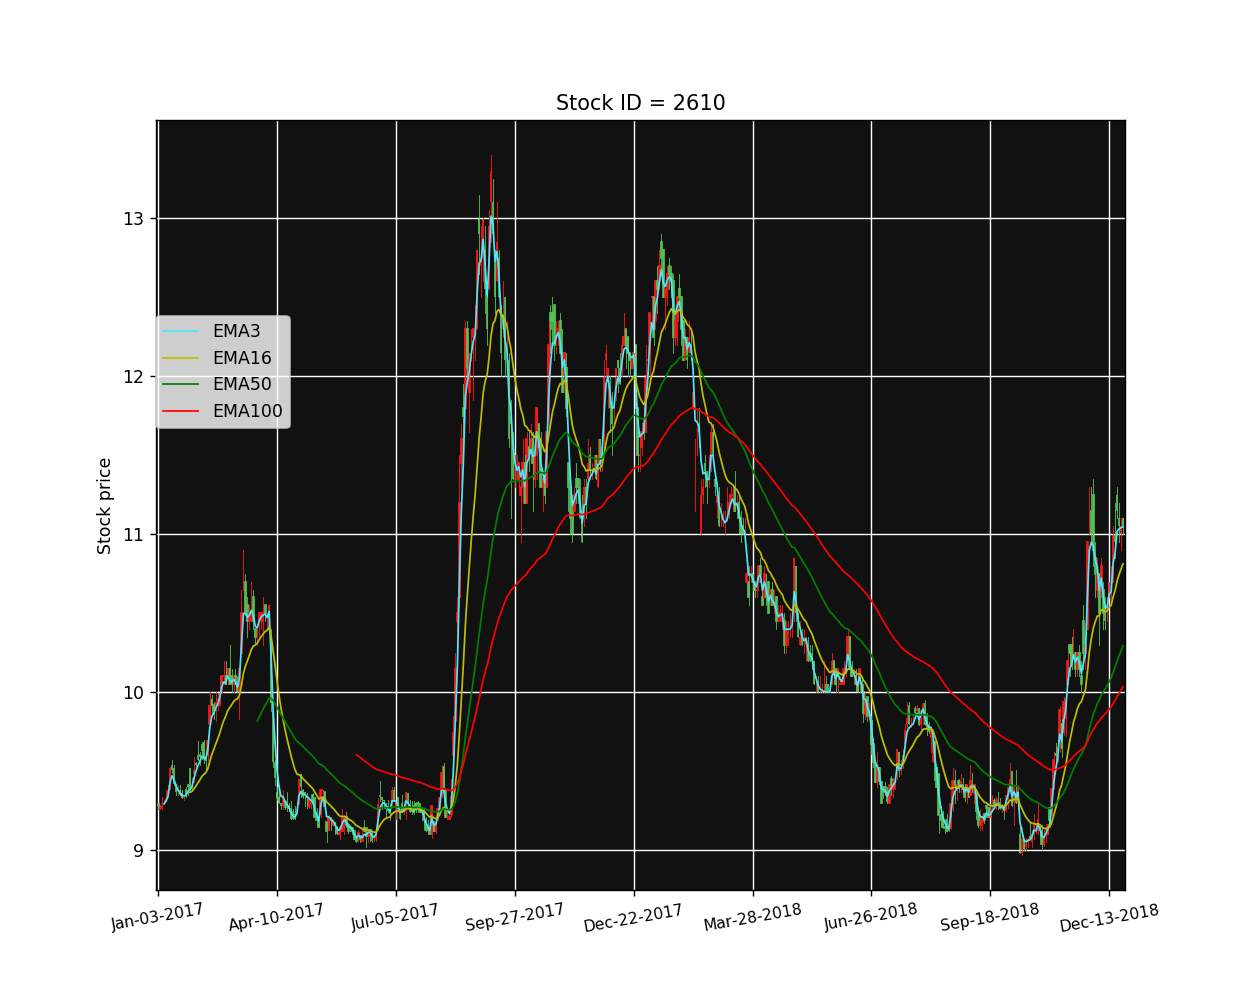

<IPython.core.display.Javascript object>


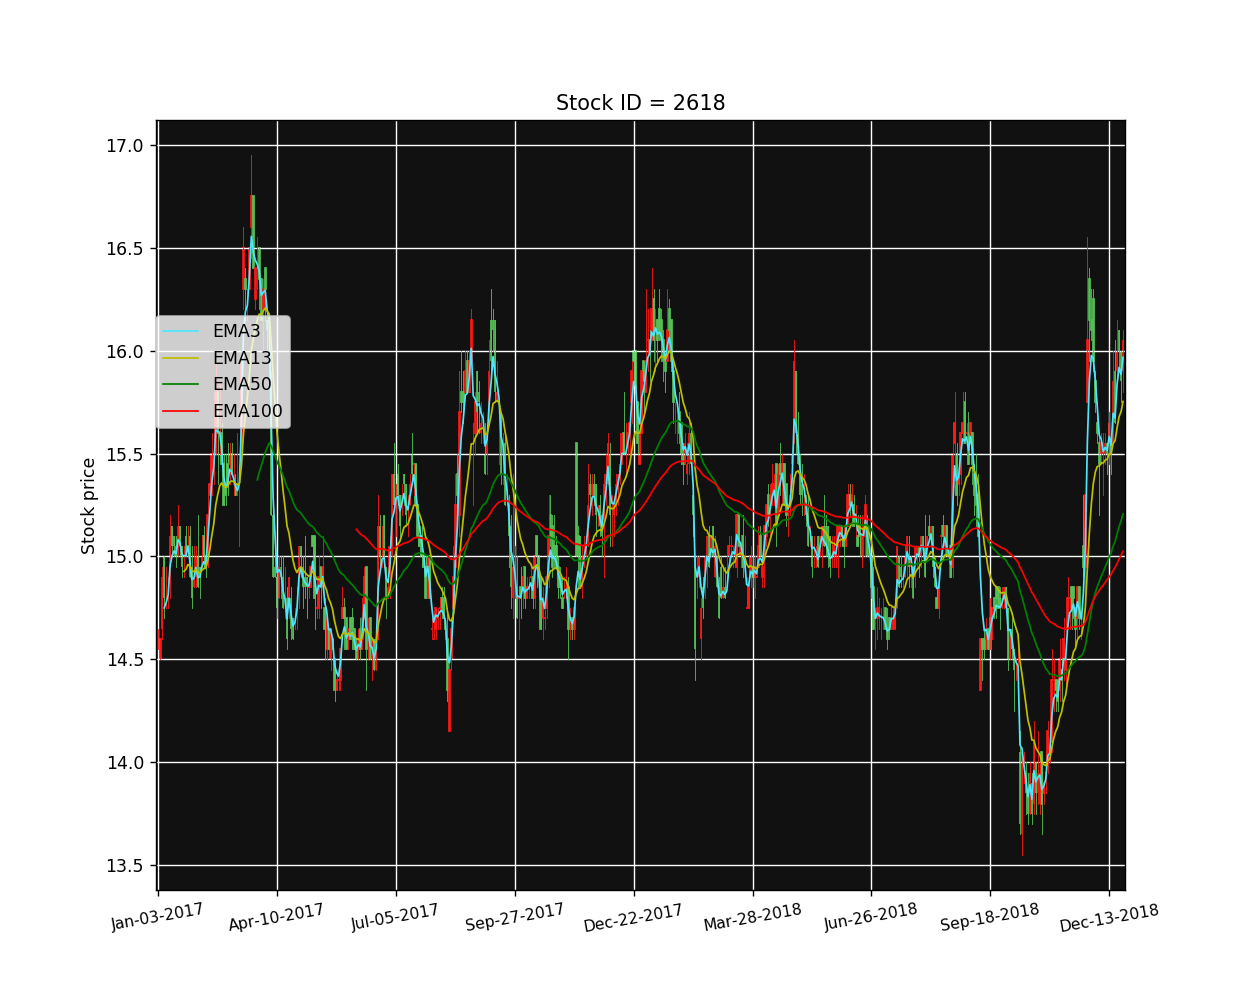

<IPython.core.display.Javascript object>


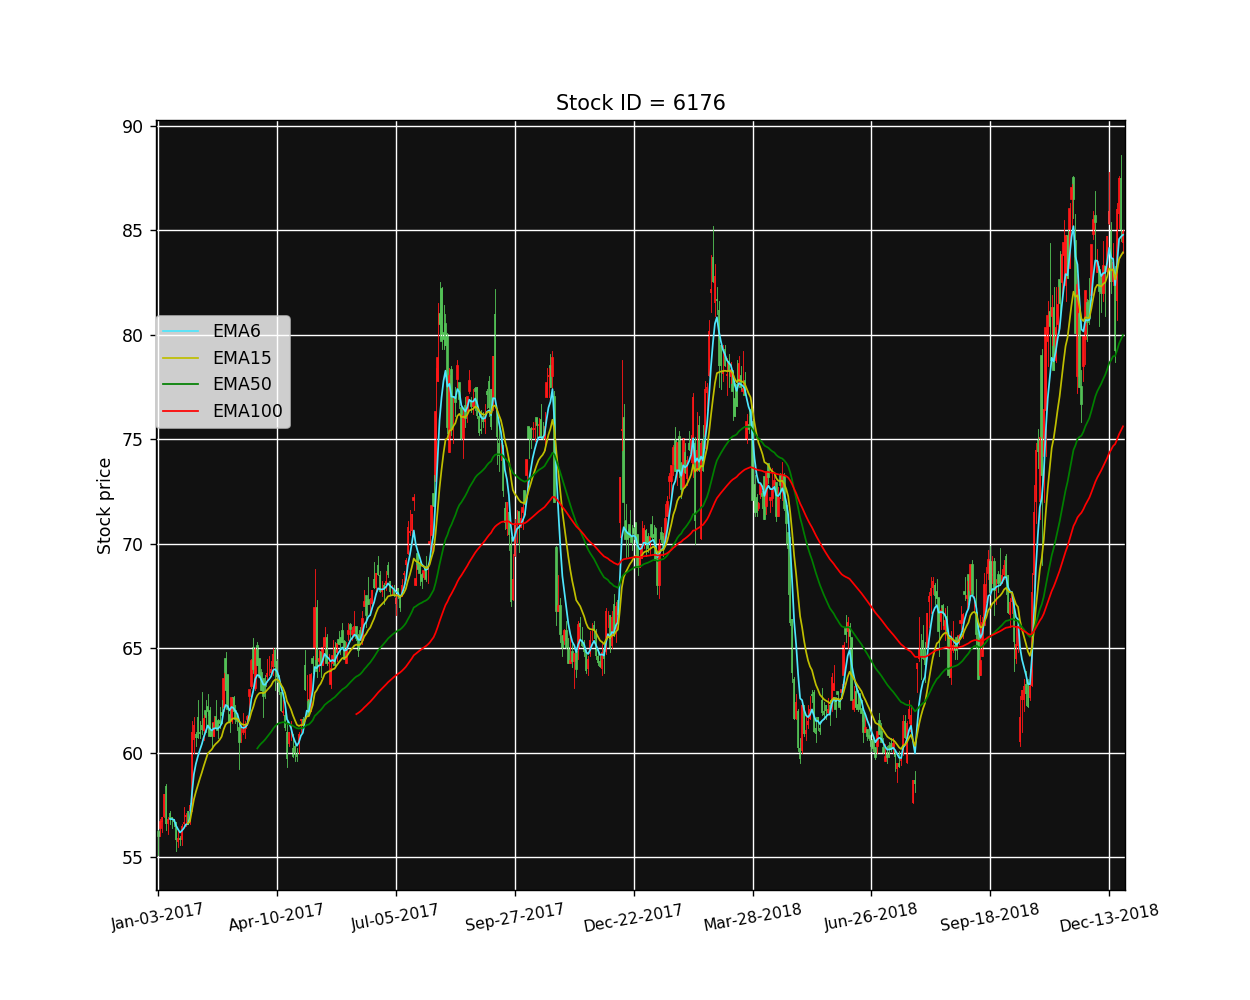

<IPython.core.display.Javascript object>


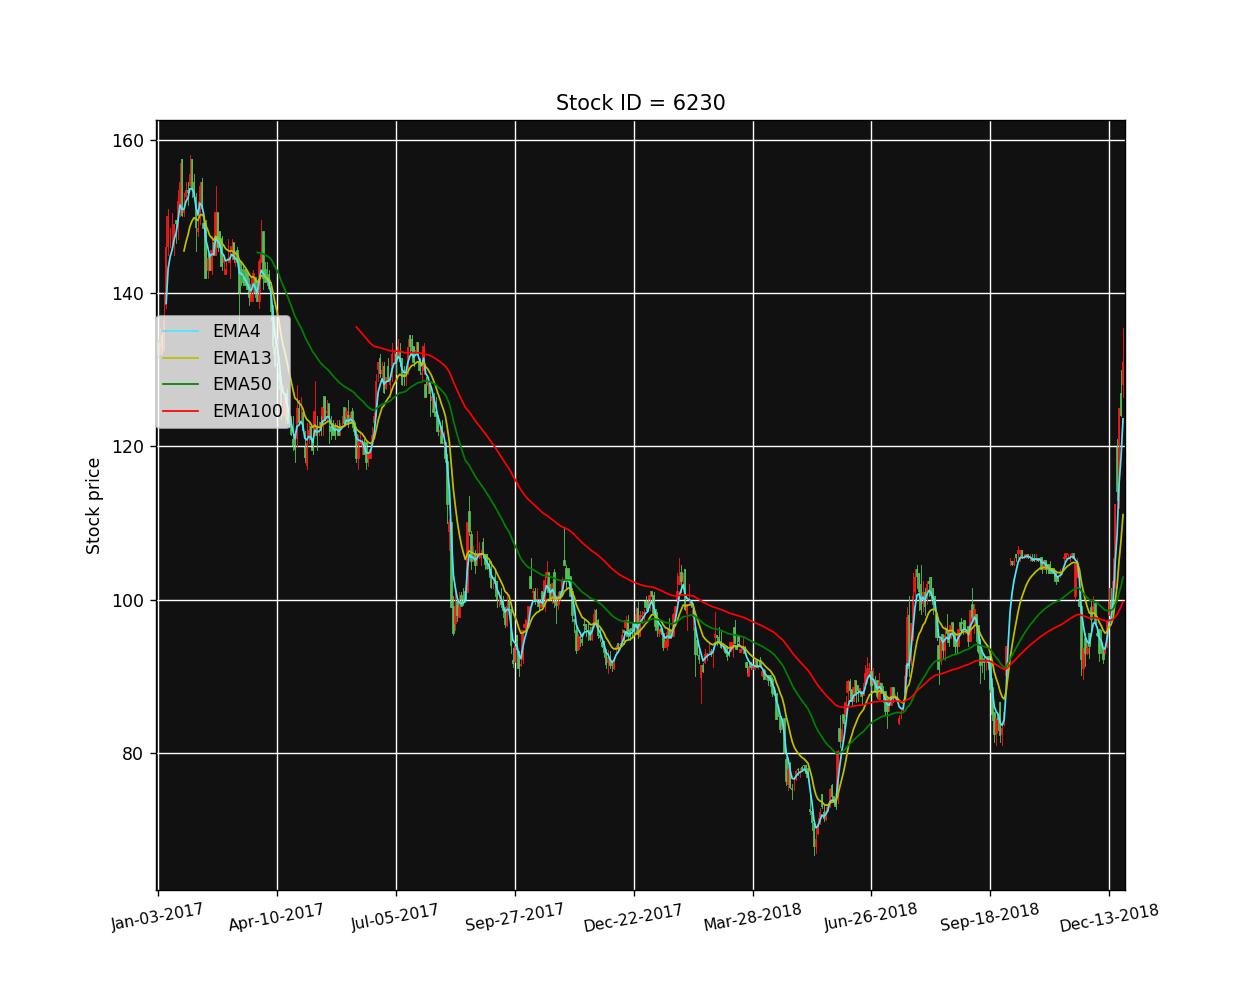

<IPython.core.display.Javascript object>


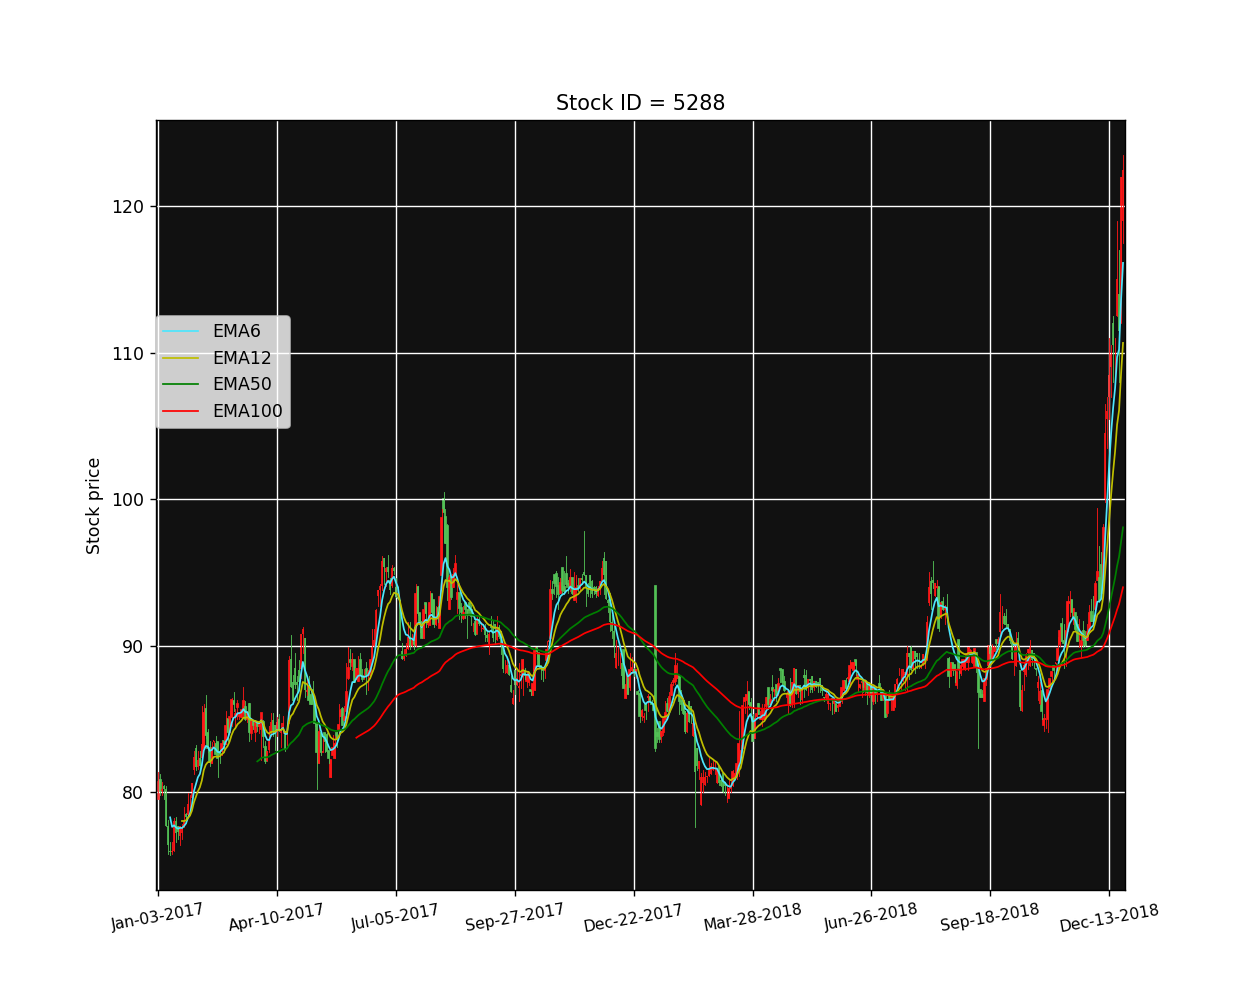

<IPython.core.display.Javascript object>


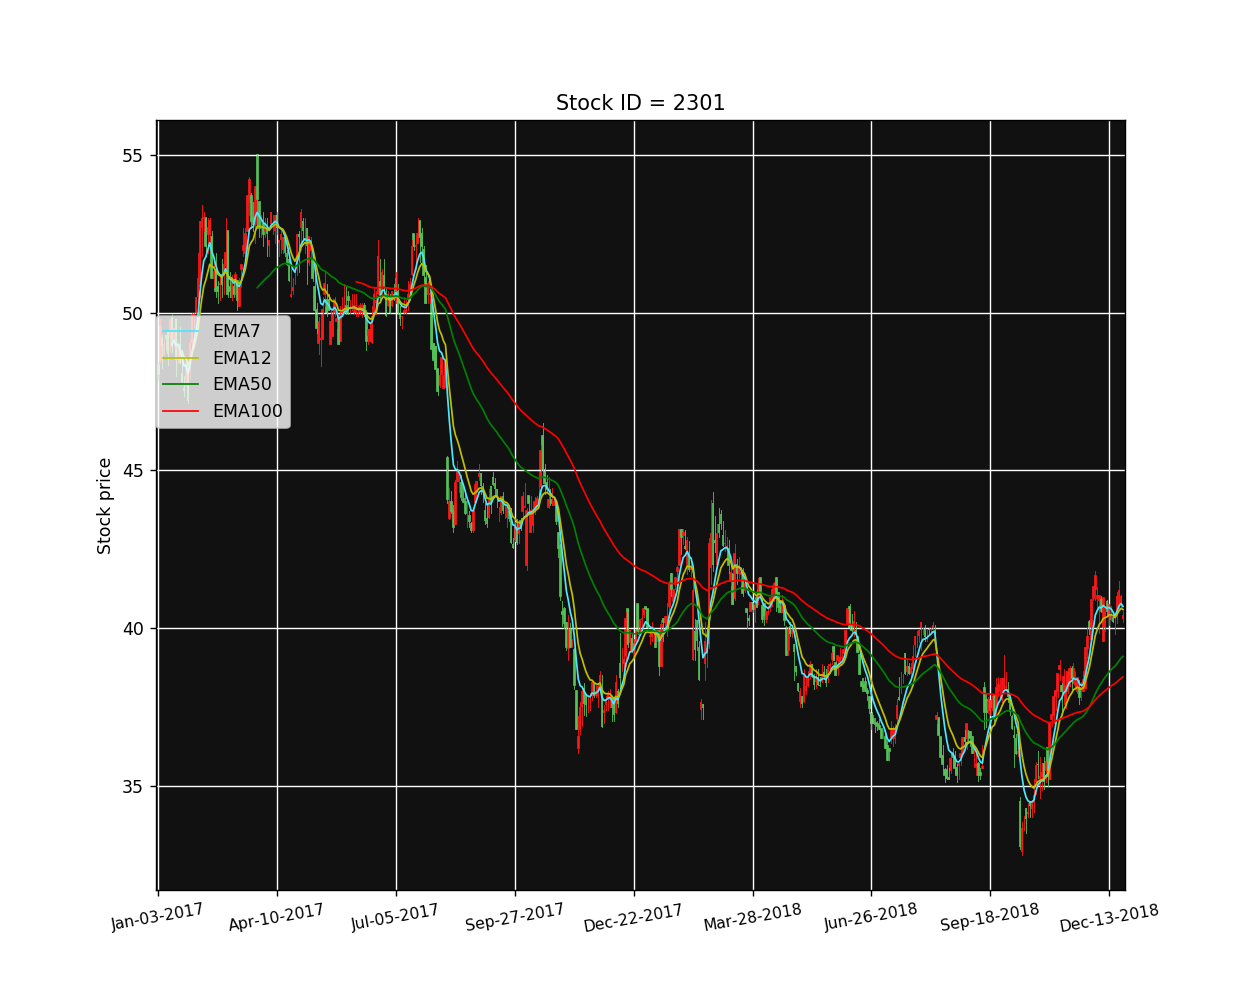

<IPython.core.display.Javascript object>


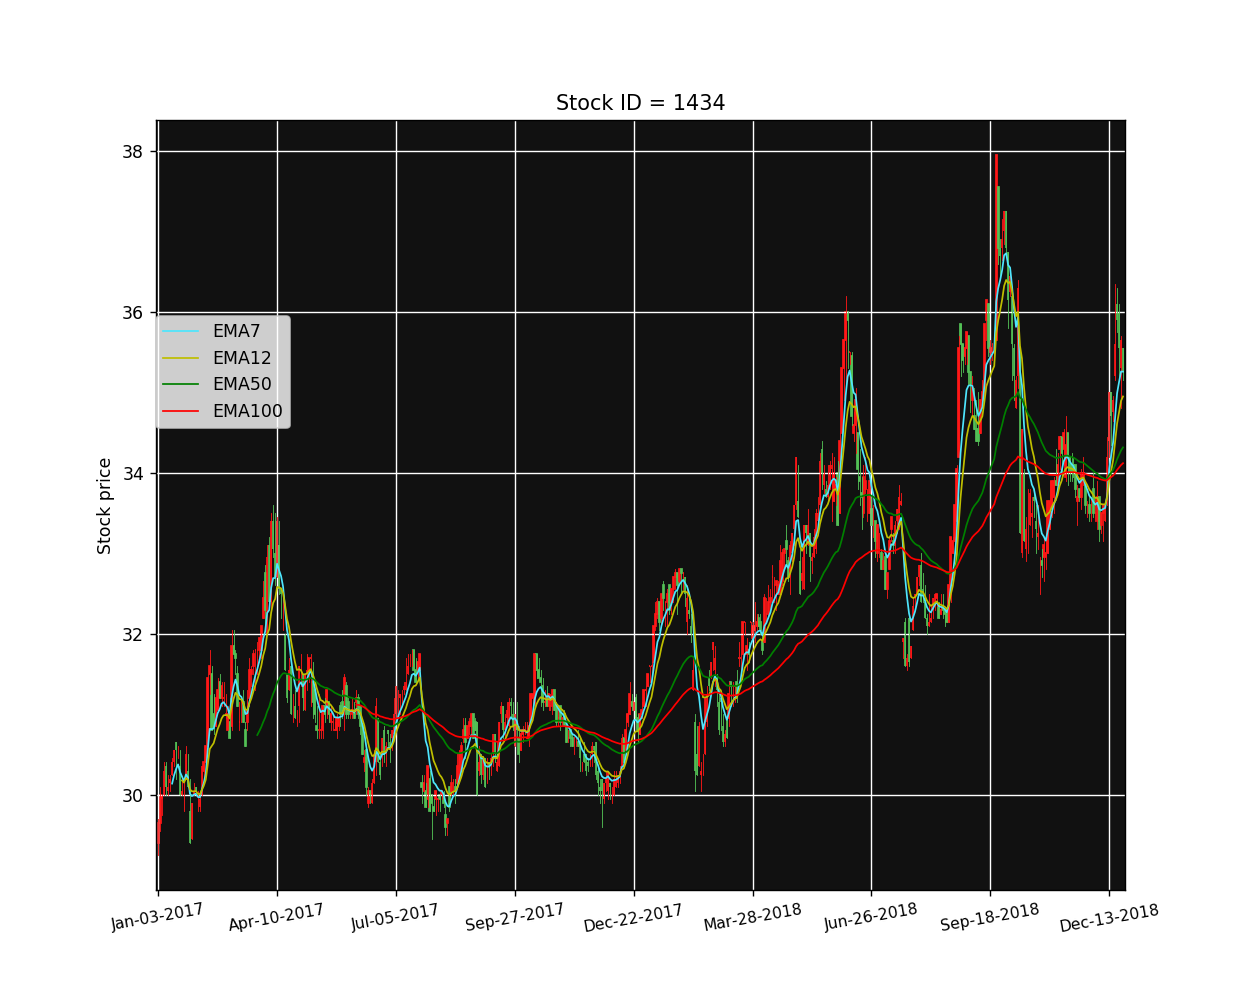

<IPython.core.display.Javascript object>


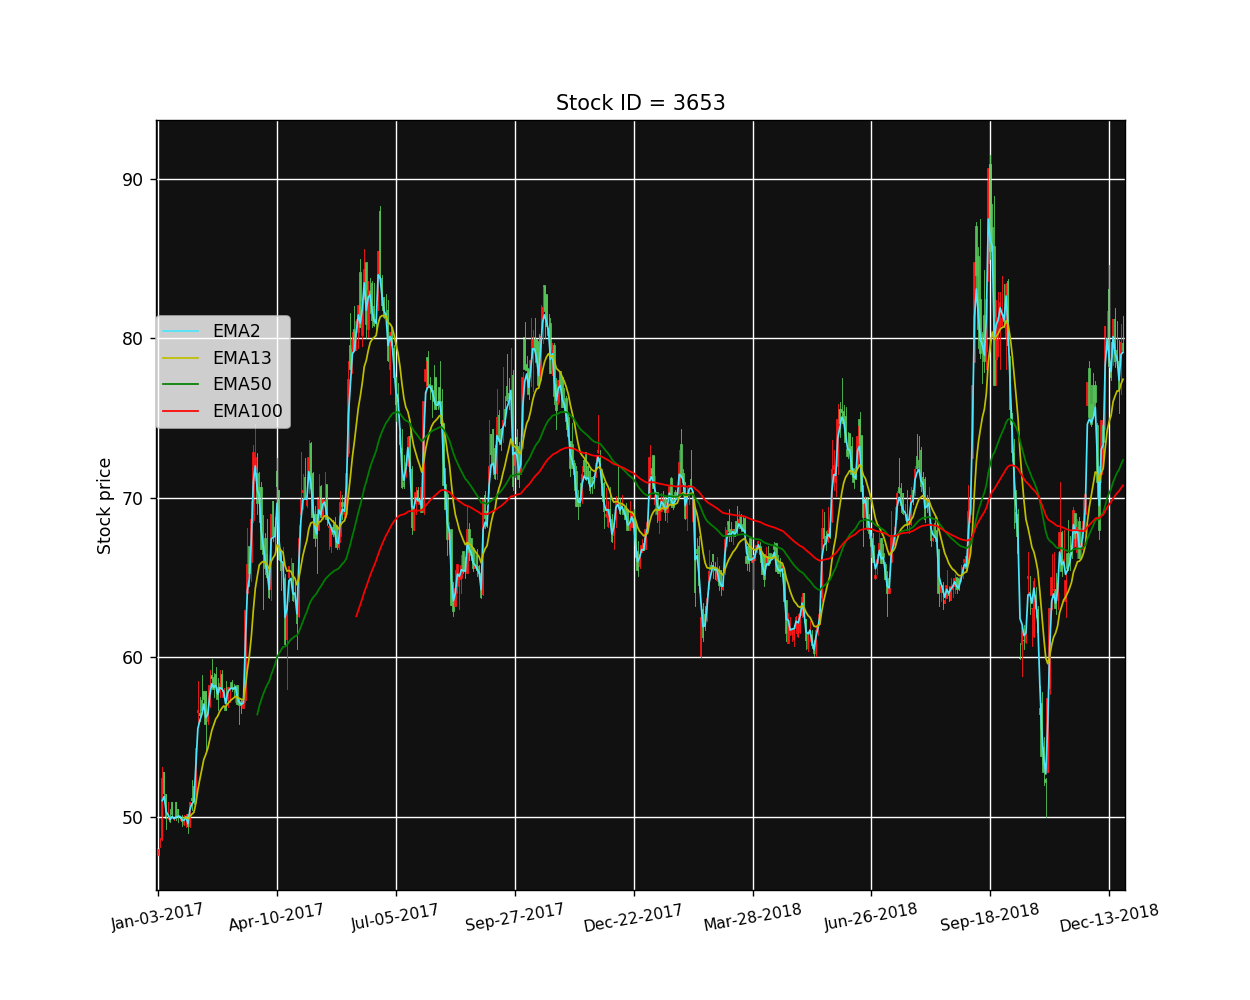

<IPython.core.display.Javascript object>


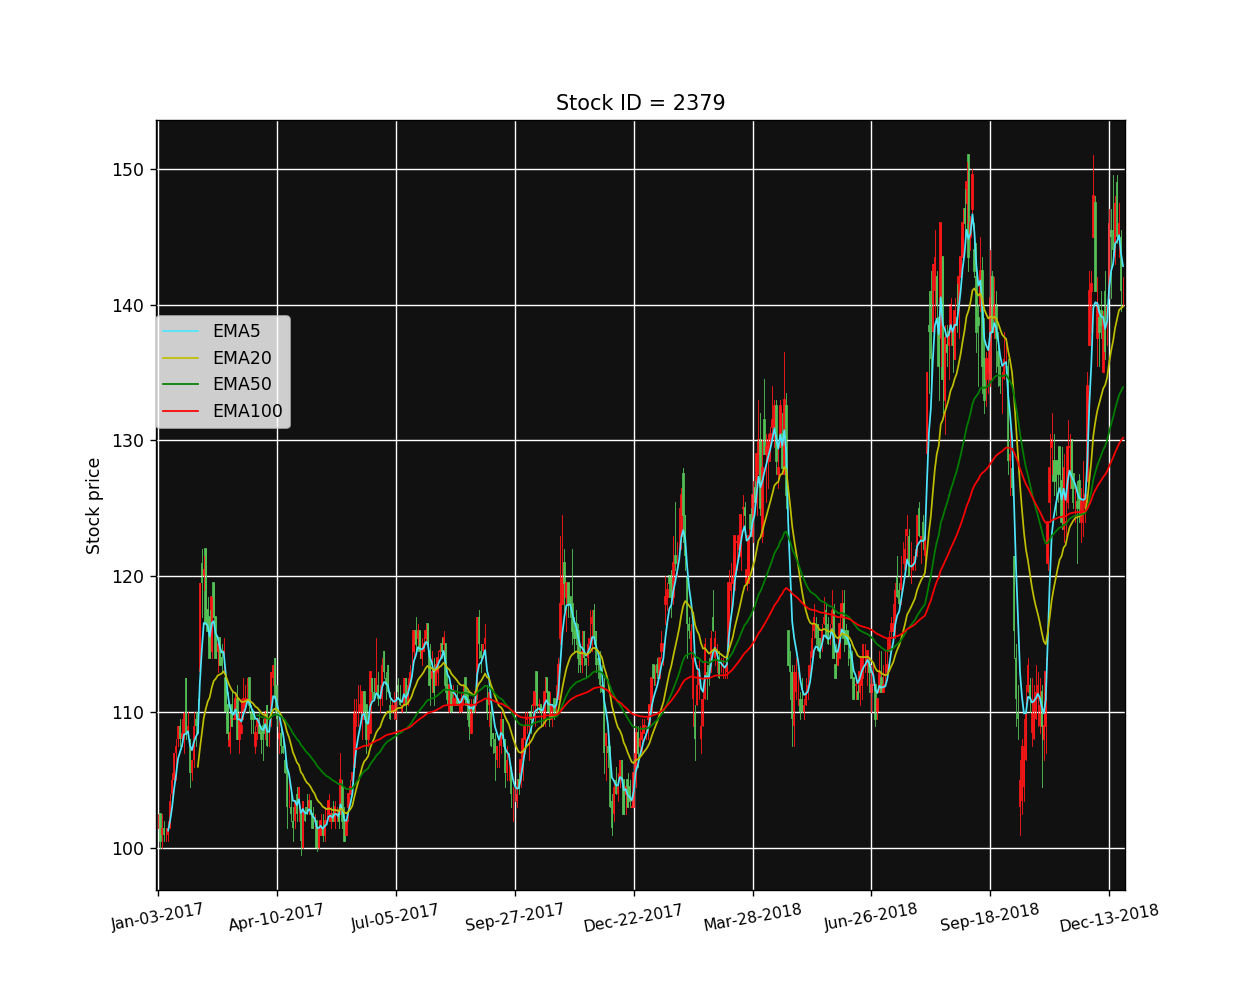

<IPython.core.display.Javascript object>


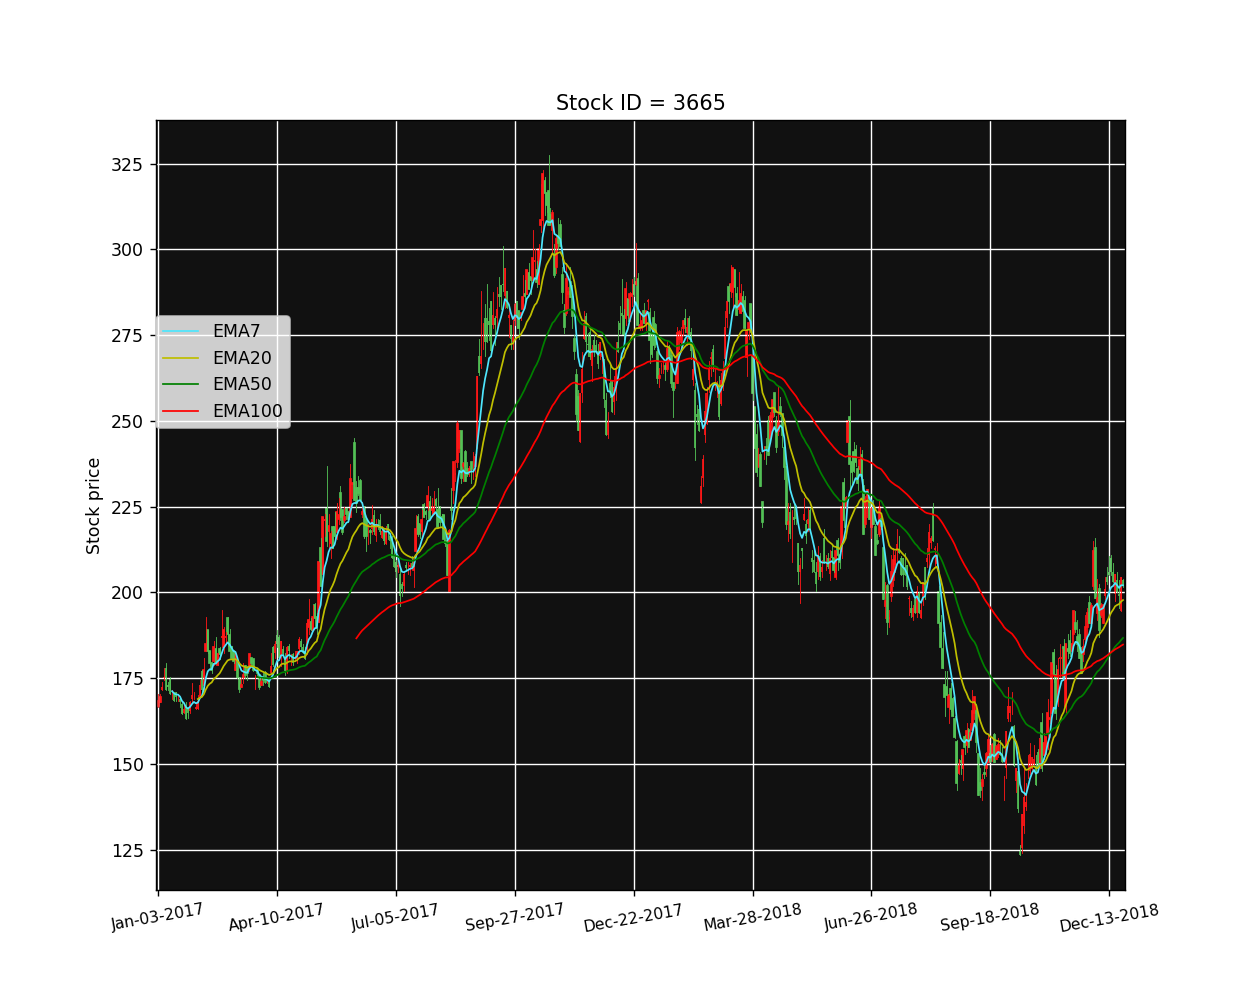

<IPython.core.display.Javascript object>


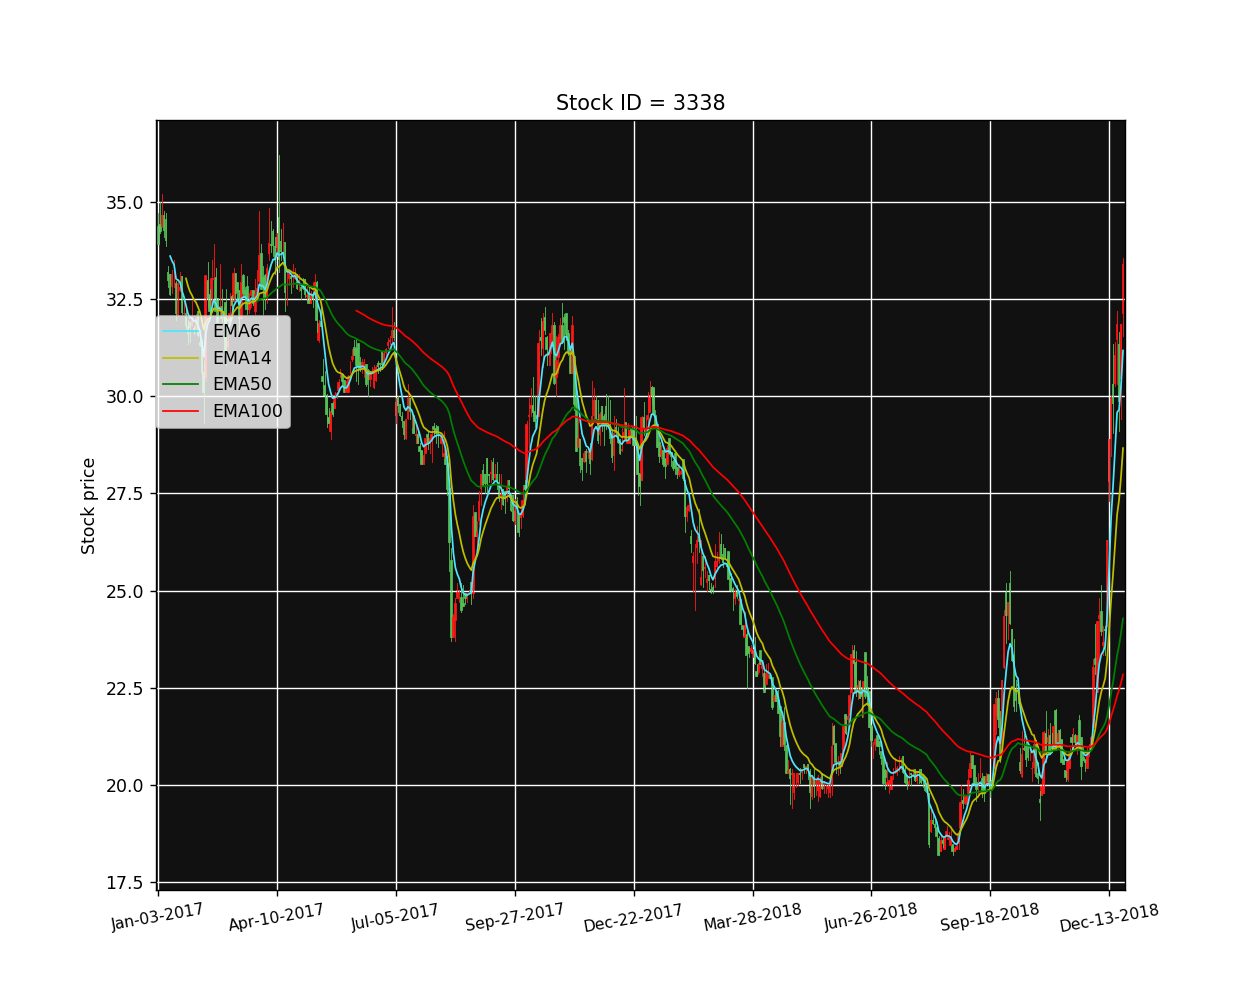

<IPython.core.display.Javascript object>


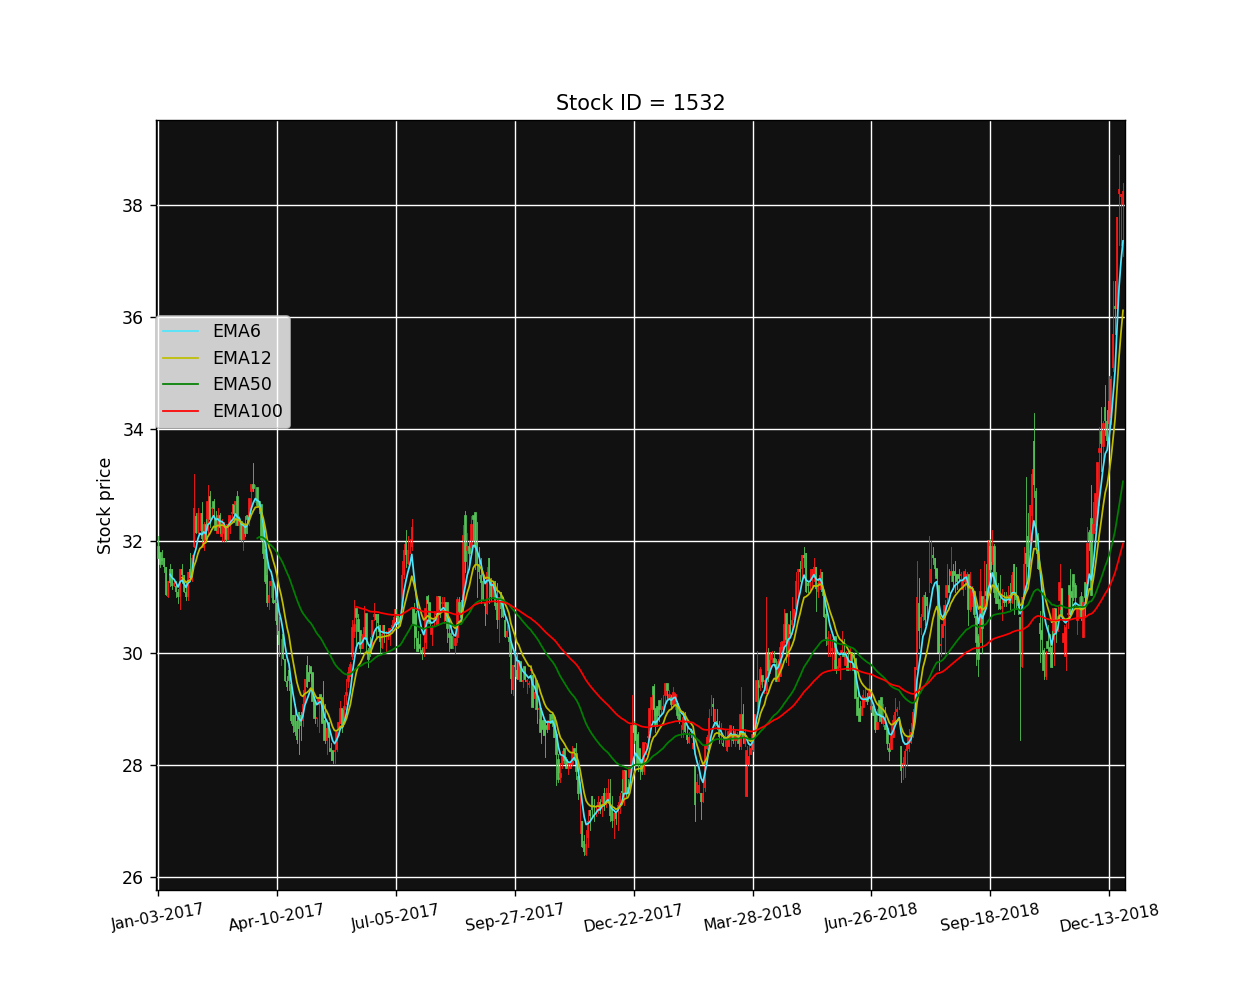

<IPython.core.display.Javascript object>


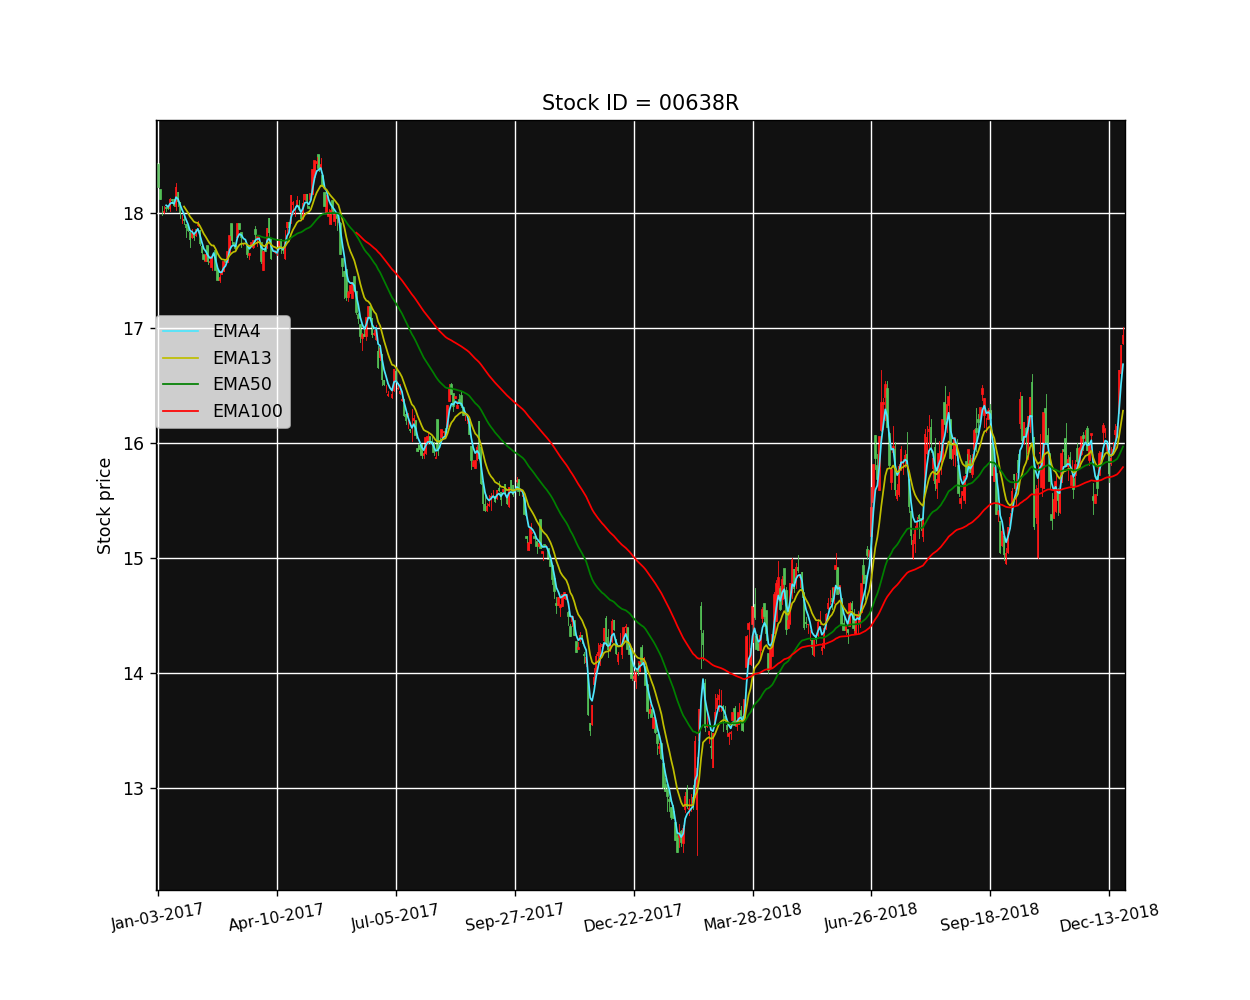

<IPython.core.display.Javascript object>


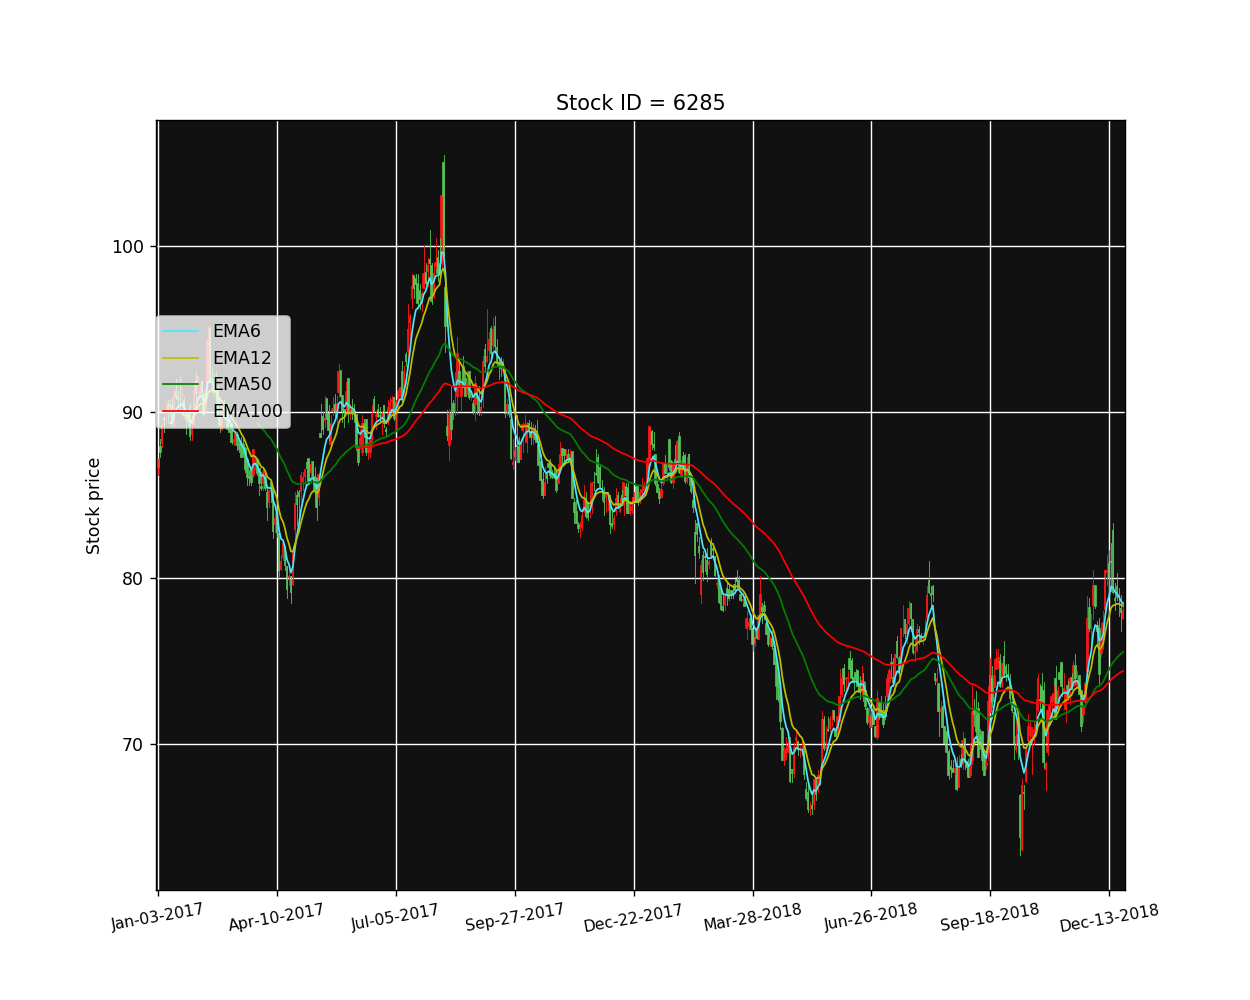

<IPython.core.display.Javascript object>


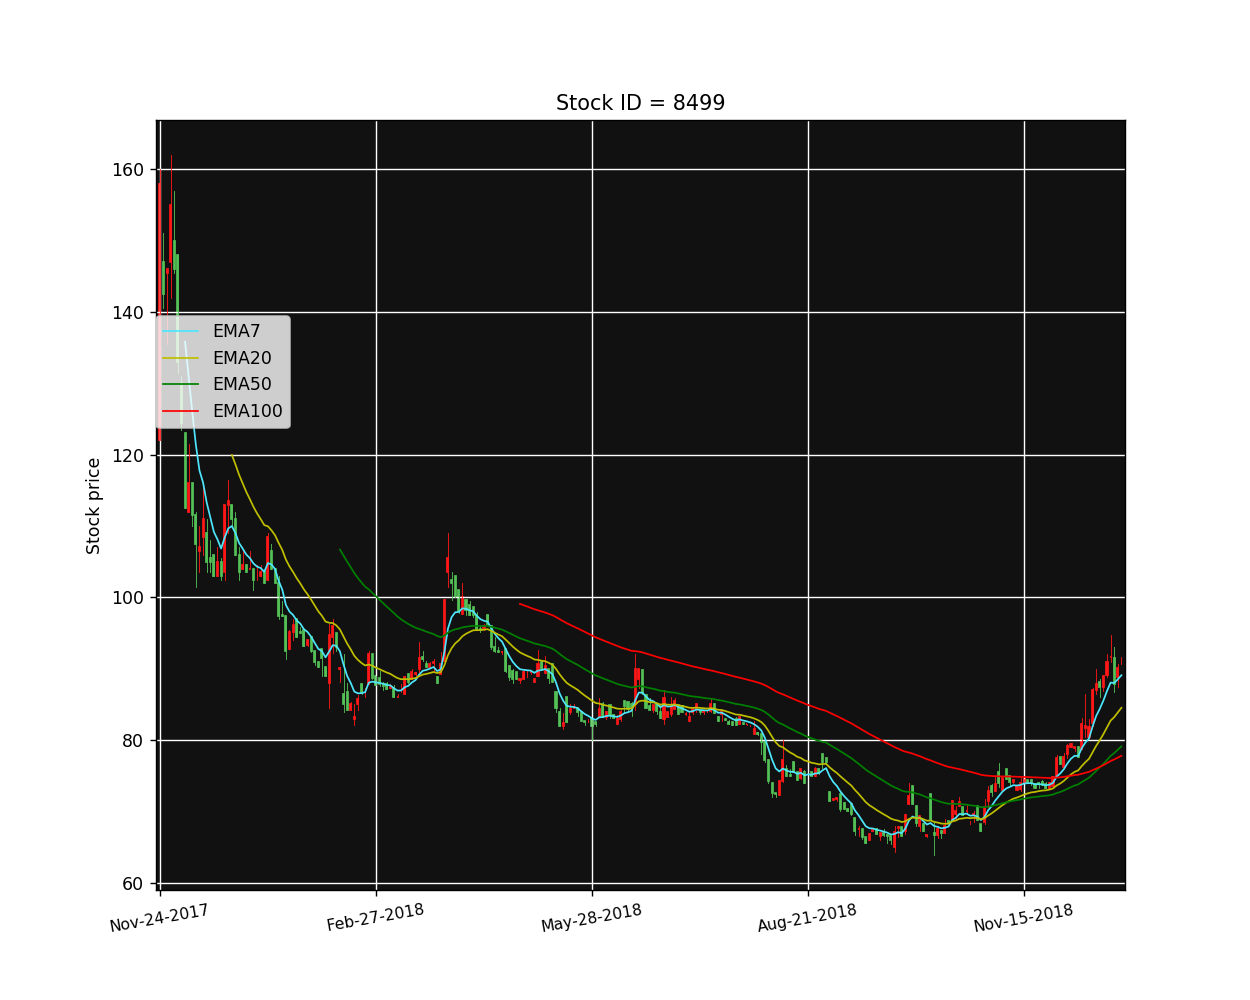

<IPython.core.display.Javascript object>


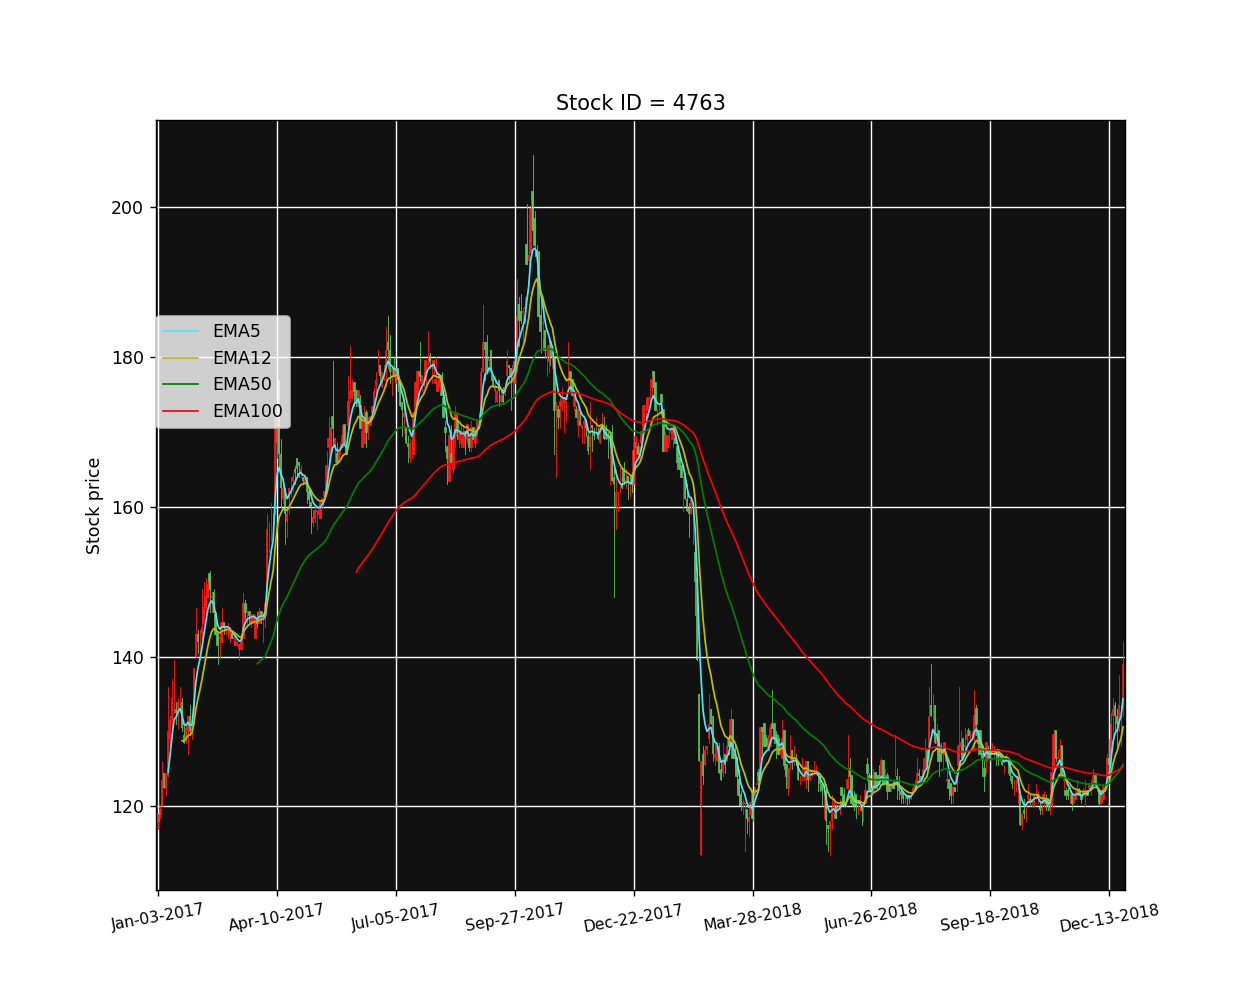

<IPython.core.display.Javascript object>


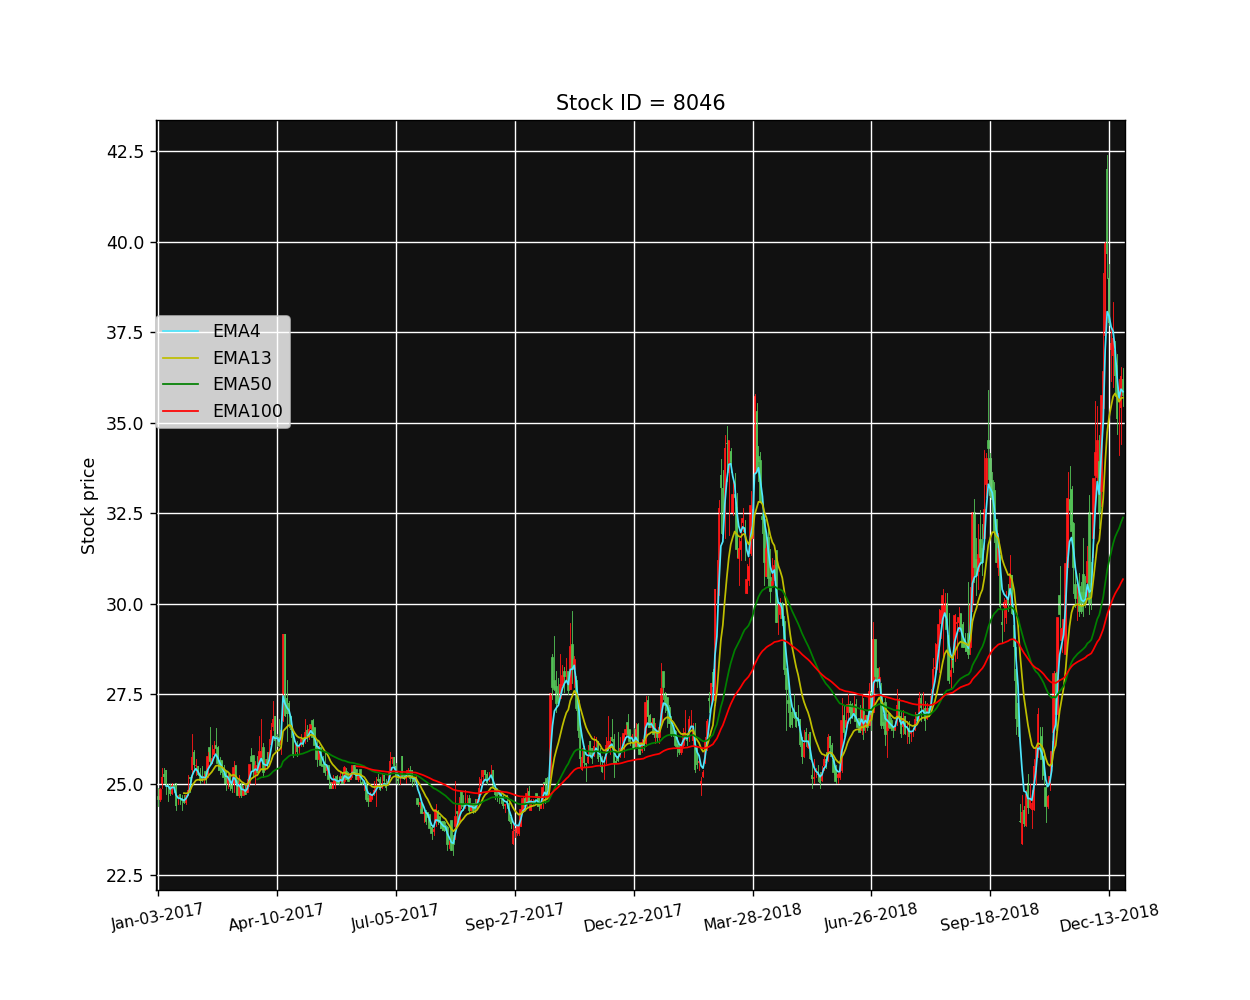

<IPython.core.display.Javascript object>


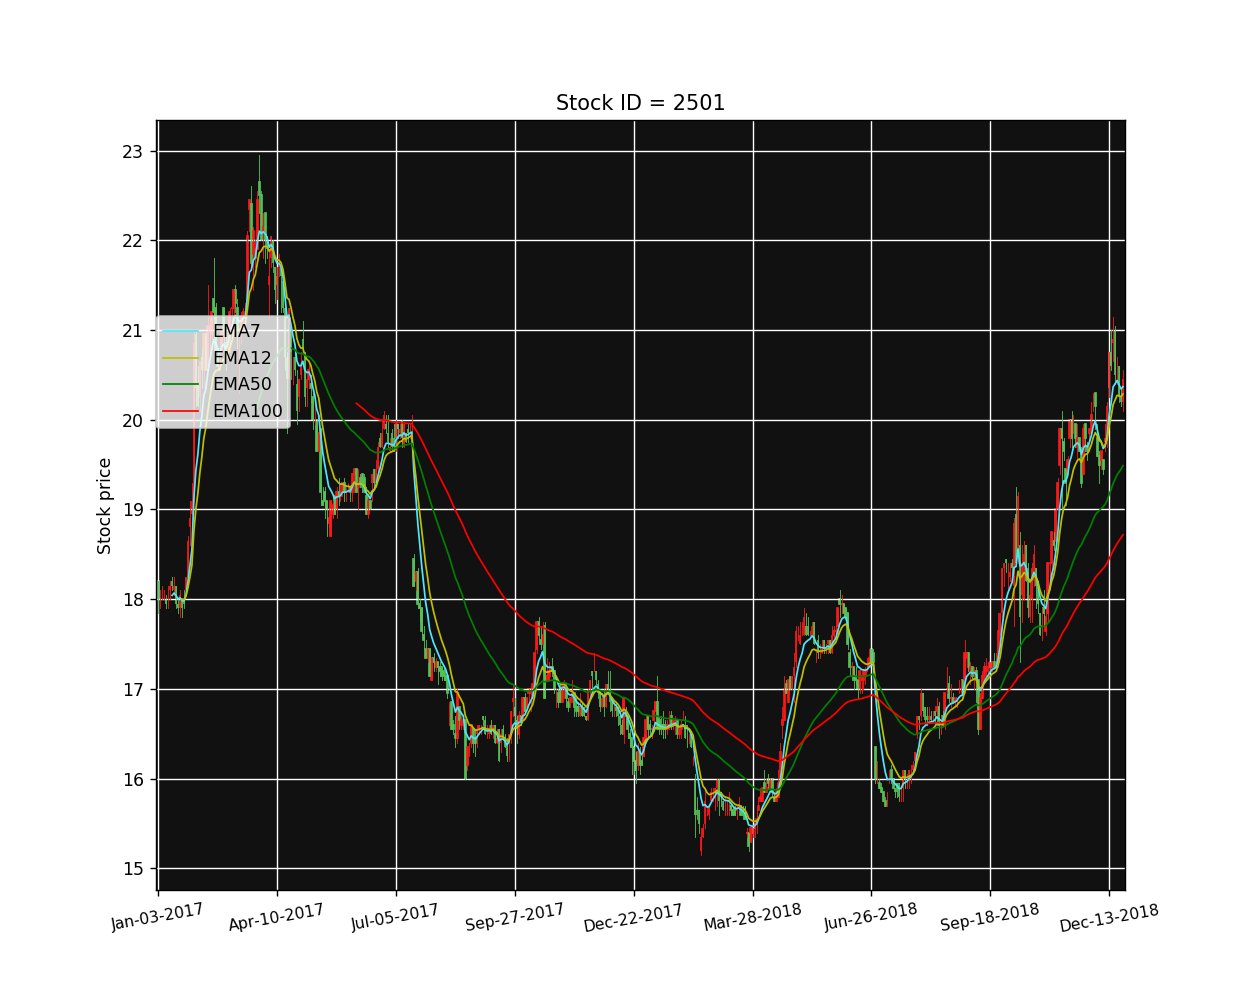

<IPython.core.display.Javascript object>


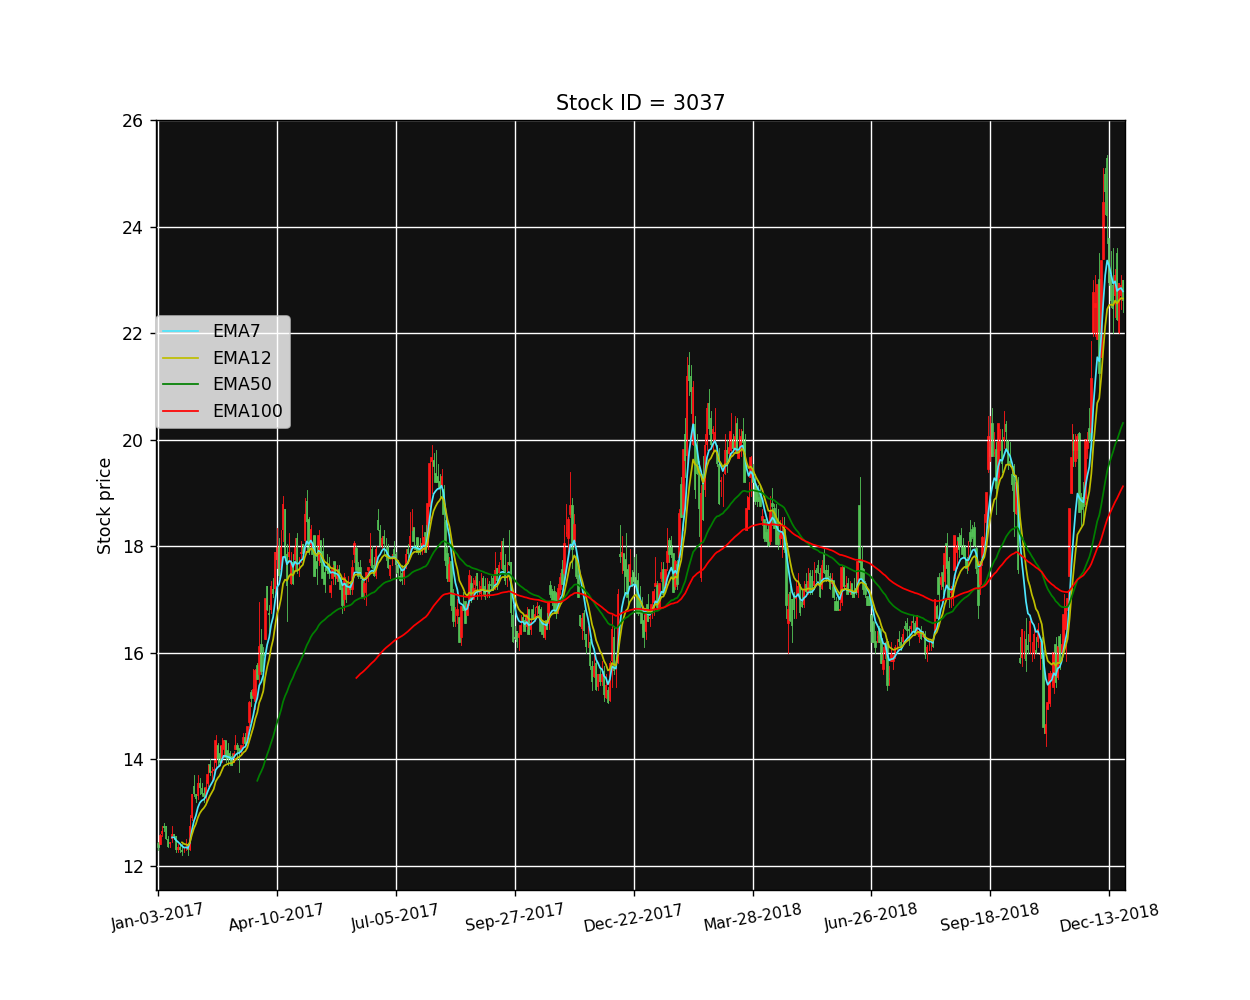

In [18]:
%matplotlib notebook
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
from matplotlib import ticker as mticker
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY
from matplotlib.dates import MonthLocator,MONTHLY

def weekday_candlestick(ohlc_data, ax, fmt='%b-%d-%Y', freq=10, **kwargs):
# Wrapper function for matplotlib.finance.candlestick_ohlc that artificially spaces data to avoid gaps from weekends
    # Convert data to numpy array
    ohlc_data_arr = np.array(ohlc_data)[::-1]
    ohlc_data_arr2 = np.hstack([np.arange(ohlc_data_arr[:,0].size)[:,np.newaxis], ohlc_data_arr[:,1:]])
    ndays = ohlc_data_arr2[:,0]  # array([0, 1, 2, ... n-2, n-1, n])
    # Convert matplotlib date numbers to strings based on `fmt`
    dates = mdates.num2date(ohlc_data_arr[:,0])
    date_strings = []
    for date in dates:
        date_strings.append(date.strftime(fmt))
    # Plot candlestick chart
    candlestick_ohlc(ax, ohlc_data_arr2, **kwargs, colorup='#ff1717', colordown='#53c156')
    # Format x axis
    ax.set_xticks(ndays[::freq])
    ax.set_xticklabels(date_strings[::freq], rotation=10,fontsize=9)
    ax.set_xlim(ndays.min()-1, ndays.max()+1)
    plt.ylabel('Stock price')
    plt.show()

# Create figures and save them as JPEG files 
for i in range(len(res_list)):
    current_df = new_dataframe(backtest_df[i])
    fig = plt.figure(facecolor='w',figsize=(10,8))
    axes = fig.add_subplot(111,facecolor="#111111")
    axes.grid(True, color='w')
    weekday_candlestick(current_df, ax=axes, fmt='%b-%d-%Y', freq=60 ,width=0.3)
    # Set the plot titles
    axes.set_title("Stock ID = "+res_list[i])
    # add EMA5, EMA20, EMA50, EMA100
    av1 = np.array(current_df['收盤價'],dtype=float)[::-1]
    EMA_1 = roi_list[i][3]
    EMA_2 = roi_list[i][4]
    axes.plot(range(EMA_1,len(av1)),talib.EMA(av1,EMA_1)[-(len(av1)-EMA_1):],'#4ee6fd',label="EMA"+str(EMA_1), linewidth=1.0)
    axes.plot(range(EMA_2,len(av1)),talib.EMA(av1,EMA_2)[-(len(av1)-EMA_2):],'y',label="EMA"+str(EMA_2), linewidth=1.0)
    axes.plot(range(50,len(av1)),talib.EMA(av1,50)[-(len(av1)-50):],'g',label="EMA50", linewidth=1.0)
    axes.plot(range(100,len(av1)),talib.EMA(av1,100)[-(len(av1)-100):],'r',label="EMA100", linewidth=1.0)
    plt.legend(bbox_to_anchor=(0,0.6), loc=3, borderaxespad=0.)
    plt.savefig(res_list[i]+'.jpg')